# 文件分類

本次練習為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具  

In [208]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from matplotlib import font_manager

設定中文字體 

In [234]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


Text(0.5, 1.0, '聲量圖')

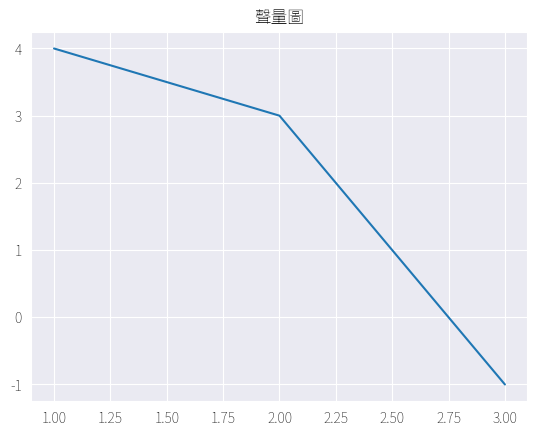

In [210]:
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

# 2. 文字前處理
`聯合新聞.csv`裡面包含了要分析的 udn 新聞資料。
- 版別：全球(global)、社會(social)、產經(produce)、股市(stock)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無
 

In [211]:
# 文字前處理
udn = pd.read_csv("data/聯合新聞.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,NaN,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站，在其他盟友對提供軍援猶豫不決時，展現對烏克蘭的支持。烏克蘭接待席科斯基（Radoslaw Sikorski）來訪時，表示希望迅速解決波蘭卡車司機封堵邊界的問題，並說波蘭外長這次訪問為兩國關係翻開「新頁」。在前任政府執政下，波蘭與烏克蘭關係緊張。俄羅斯過去幾週加強了空襲。席科斯基訪問時，烏克蘭空襲警報響起，警告可能有新的俄羅斯突擊行動。席科斯基在結束訪問的記者會上說：「如果西方動員起來，對於何方將勝出，我絲毫沒有懷疑，但最終還是必須開始動員。」他說，西方經濟體「比俄羅斯富裕20倍」，但莫斯科「已將其經濟切換成戰爭模式」。他說：「我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多。因為戰爭不是靠著戰術戰鬥贏的，戰爭是透過生產打贏的。」法新社報導，俄烏戰爭打了近兩年，儘管烏克蘭官員努力遊說，基輔盟國對這場衝突漸漸感到疲倦。在美國，聯邦參議院領袖19日表示，華府無法在年底前通過對烏克蘭的新援助。在歐洲，匈牙利擋下歐洲聯盟（EU）價值500億歐元的援烏方案，儘管歐盟與烏克蘭啟動正式入盟談判，讓烏克蘭取得象徵性勝利，但真正的入盟尚需數年時間。席科斯基這次訪問是為了讓基輔安心，而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的。俄烏戰爭於2022年2月開打時，歐盟取消烏克蘭貨運公司進入歐盟的限制，以緩解進出烏克蘭的貨運量。但波蘭卡車司機說，此舉導致他們的營收變少，因此一直封鎖波蘭與烏克蘭的邊界，而烏克蘭的進出口嚴重仰賴這條路線。烏克蘭外交部長庫列巴（Dmytro Kuleba）稍早提到這個問題時跟席科斯基說：「首先要做的是解除邊界封鎖，因為我們的友好關係籠罩在邊界遭圍堵的陰影下，這種情況令人無法接受且是有害的。」波蘭副基礎建設部長甘卡茲（Pawel Gancarz）稍後在基輔與席科斯基一同舉行的記者會上說：「我們希望這個問題能在耶誕節前、在今年年底前解決。」,UDN
1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,NaN,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，協助俄國規避制裁的金融機構也恐成制裁對象。華府正試圖加強對俄國施壓。綜合法新社和路透社報導，已有多家公司因支援俄羅斯國防工業而受制裁，如果金融機構支持這些公司，美方將根據這項行政命令對金融機構祭出所謂的「次級制裁」。白宮表示，這項行政命令也授權華府擴大對部分俄國商品的進口禁令，例如海產和鑽石。白宮國家安全顧問蘇利文（Jake Sullivan）在聲明中說：「我們正發出明確的訊息：任何支持俄羅斯非法戰爭活動者，恐怕都會被踢出美國金融體系。」蘇利文表示，新的制裁措施將「持續施壓俄羅斯戰爭機器及其推手」，還說先前的措施已「大大削弱」俄軍實力。俄羅斯軍隊長期以來被視為全球最強大的軍隊之一，近幾個月來仰賴北韓和伊朗進口。北韓和伊朗也都受到西方制裁。美國對烏克蘭軍事援助的資金即將耗盡，美國和盟邦正尋找新的方法來減緩俄羅斯戰力。哥倫比亞大學（Columbia University）制裁專家費希曼（Edward Fishman）說，華府早已有權制裁非俄羅斯金融機構，但今天的行政命令凸顯「外國金融機構面臨切實風險，其中許多機構似乎還沒有意識到這一點」。這波措施明確指出，金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易，包括部分關鍵物品的銷售，美方就可以鎖定這些金融機構。不具名的政府高層官員透露，這項命令是與盟邦協調發布。然而，自俄烏戰爭爆發以來，俄國一直加快腳步減少與西方接觸，避免以美元、歐元、英鎊和日圓進行貿易。與此同時，隨著西方機構退出，中國最大的數家銀行自俄烏戰爭開打以來，已向俄羅斯借出價值數十億美元的人民幣信貸。美國財政部副部長艾迪耶摩（Wally Adeyemo）表示，中國、土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁，新措施將針對規模較小的機構。艾迪耶摩接受財經媒體CNBC訪問時說，俄羅斯一直在設立幌子公司來隱藏透過第3國的採購，「他們不會透過這些國家的大公司，而是透過小公司取得微電子器件、機具和引擎零件等產品」，「但這些公司全都還是必須使用金融體系」。,UDN
2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,NaN,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前線擊落3架俄羅斯蘇愷34（Su-34）戰鬥轟炸機，並稱讚這是俄烏交戰22個月來的一大戰果。俄羅斯軍方並未提及這起事件，但俄國的部落客承認俄方確實有折損，分析家指出，烏軍可能用了美國供應的愛國者飛彈，但路透社無法獨立證實前述這些消息。烏克蘭空軍司令歐勒什丘克（Mykola Oleshchuk）於通訊應用程式Telegram寫道：「今天中午在南部戰區，掉了3架俄羅斯蘇愷34戰鬥轟炸機！」空軍發言人伊納特（Yuri Ihnat）告訴烏克蘭國營電視台，這是一場「精心策劃的行動」。他說道，「在我們確實的統計數據中，已經有一段時間沒有出現蘇愷34」，更形容蘇愷34是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一。澤倫斯基在晚間談話影片中，讚揚敖德薩地區（Odesa）防空部隊擊落赫松地區（Kherson）上空的這些蘇愷34。俄軍2022年2月全面入侵烏克蘭的頭幾天，就占領了赫松地區大片領土，此後烏軍試圖收復失土，今年11月在赫松地區的第聶伯河（Dnipro River）東岸建立陣地。總部位於俄羅斯的「歐亞日報」（Eurasia Daily）稱烏克蘭說法是可信的，基輔當局可能從第聶伯河西岸，發射針對高空目標、射程可達160公里的愛國者飛彈。烏克蘭航空專家羅曼能柯（Valeriy Romanenko）向烏國當地廣播電台表示，他認為愛國者飛彈擊落俄軍戰機的可能性很高，還說俄軍沒有充分考量到愛國者飛彈的射程達到160公里。,UDN


In [212]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8803
date range: ('2023-12-23 00:04:00', '2024-01-13 23:54:00')
category: 
artCatagory
產經    2760
全球    2570
社會    1817
股市    1655
生活       1
Name: count, dtype: int64


In [213]:
# 去除artCatagory是生活
udn = udn[udn['artCatagory'] != '生活']

# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8802
date range: ('2023-12-23 00:04:00', '2024-01-13 23:54:00')
category: 
artCatagory
產經    2760
全球    2570
社會    1817
股市    1655
Name: count, dtype: int64


＃我們將聯合時報的產經版面與股市版面資料匯總，對應到自由時報的財經版面

In [214]:
udn.loc[udn['artCatagory'].isin(['產經', '股市']), 'artCatagory'] = '財經'

# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8802
date range: ('2023-12-23 00:04:00', '2024-01-13 23:54:00')
category: 
artCatagory
財經    4415
全球    2570
社會    1817
Name: count, dtype: int64


In [215]:
udn.to_csv('data/聯合新聞_merge.csv')

+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字） 

### 2.1 清理 

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。 

In [163]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,波蘭新外長籲西方挺烏基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,NaN,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站在其他盟友對提供軍援猶豫不決時展現對烏克蘭的支持烏克蘭接待席科斯基來訪時表示希望迅速解決波蘭卡車司機封堵邊界的問題並說波蘭外長這次訪問為兩國關係翻開新頁在前任政府執政下波蘭與烏克蘭關係緊張俄羅斯過去幾週加強了空襲席科斯基訪問時烏克蘭空襲警報響起警告可能有新的俄羅斯突擊行動席科斯基在結束訪問的記者會上說如果西方動員起來對於何方將勝出我絲毫沒有懷疑但最終還是必須開始動員他說西方經濟體比俄羅斯富裕倍但莫斯科已將其經濟切換成戰爭模式他說我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多因為戰爭不是靠著戰術戰鬥贏的戰爭是透過生產打贏的法新社報導俄烏戰爭打了近兩年儘管烏克蘭官員努力遊說基輔盟國對這場衝突漸漸感到疲倦在美國聯邦參議院領袖日表示華府無法在年底前通過對烏克蘭的新援助在歐洲匈牙利擋下歐洲聯盟價值億歐元的援烏方案儘管歐盟與烏克蘭啟動正式入盟談判讓烏克蘭取得象徵性勝利但真正的入盟尚需數年時間席科斯基這次訪問是為了讓基輔安心而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的俄烏戰爭於年月開打時歐盟取消烏克蘭貨運公司進入歐盟的限制以緩解進出烏克蘭的貨運量但波蘭卡車司機說此舉導致他們的營收變少因此一直封鎖波蘭與烏克蘭的邊界而烏克蘭的進出口嚴重仰賴這條路線烏克蘭外交部長庫列巴稍早提到這個問題時跟席科斯基說首先要做的是解除邊界封鎖因為我們的友好關係籠罩在邊界遭圍堵的陰影下這種情況令人無法接受且是有害的波蘭副基礎建設部長甘卡茲稍後在基輔與席科斯基一同舉行的記者會上說我們希望這個問題能在耶誕節前在今年年底前解決,UDN
1,2,美國加強施壓俄羅斯拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,NaN,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄國規避制裁的金融機構也恐成制裁對象華府正試圖加強對俄國施壓綜合法新社和路透社報導已有多家公司因支援俄羅斯國防工業而受制裁如果金融機構支持這些公司美方將根據這項行政命令對金融機構祭出所謂的次級制裁白宮表示這項行政命令也授權華府擴大對部分俄國商品的進口禁令例如海產和鑽石白宮國家安全顧問蘇利文在聲明中說我們正發出明確的訊息任何支持俄羅斯非法戰爭活動者恐怕都會被踢出美國金融體系蘇利文表示新的制裁措施將持續施壓俄羅斯戰爭機器及其推手還說先前的措施已大大削弱俄軍實力俄羅斯軍隊長期以來被視為全球最強大的軍隊之一近幾個月來仰賴北韓和伊朗進口北韓和伊朗也都受到西方制裁美國對烏克蘭軍事援助的資金即將耗盡美國和盟邦正尋找新的方法來減緩俄羅斯戰力哥倫比亞大學制裁專家費希曼說華府早已有權制裁非俄羅斯金融機構但今天的行政命令凸顯外國金融機構面臨切實風險其中許多機構似乎還沒有意識到這一點這波措施明確指出金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易包括部分關鍵物品的銷售美方就可以鎖定這些金融機構不具名的政府高層官員透露這項命令是與盟邦協調發布然而自俄烏戰爭爆發以來俄國一直加快腳步減少與西方接觸避免以美元歐元英鎊和日圓進行貿易與此同時隨著西方機構退出中國最大的數家銀行自俄烏戰爭開打以來已向俄羅斯借出價值數十億美元的人民幣信貸美國財政部副部長艾迪耶摩表示中國土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁新措施將針對規模較小的機構艾迪耶摩接受財經媒體訪問時說俄羅斯一直在設立幌子公司來隱藏透過第國的採購他們不會透過這些國家的大公司而是透過小公司取得微電子器件機具和引擎零件等產品但這些公司全都還是必須使用金融體系,UDN
2,3,俄烏交戰來一大戰果烏克蘭稱擊落俄軍架蘇愷專家愛國者飛彈建功,2023-12-23 17:49:00,全球,NaN,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交戰個月來的一大戰果俄羅斯軍方並未提及這起事件但俄國的部落客承認俄方確實有折損分析家指出烏軍可能用了美國供應的愛國者飛彈但路透社無法獨立證實前述這些消息烏克蘭空軍司令歐勒什丘克於通訊應用程式寫道今天中午在南部戰區掉了架俄羅斯蘇愷戰鬥轟炸機空軍發言人伊納特告訴烏克蘭國營電視台這是一場精心策劃的行動他說道在我們確實的統計數據中已經有一段時間沒有出現蘇愷更形容蘇愷是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一澤倫斯基在晚間談話影片中讚揚敖德薩地區防空部隊擊落赫松地區上空的這些蘇愷俄軍年月全面入侵烏克蘭的頭幾天就占領了赫松地區大片領土此後烏軍試圖收復失土今年月在赫松地區的第聶伯河東岸建立陣地總部位於俄羅斯的歐亞日報稱烏克蘭說法是可信的基輔當局可能從第聶伯河西岸發射針對高空目標射程可達公里的愛國者飛彈烏克蘭航空專家羅曼能柯向烏國當地廣播電台表示他認為愛國者飛彈擊落俄軍戰機的可能性很高還說俄軍沒有充分考量到愛國者飛彈的射程達到公里,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。 

In [164]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,波蘭新外長籲西方挺烏基輔盼迅速解除邊界封鎖波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站在其他盟友對提供軍援猶豫不決時展現對烏克蘭的支持烏克蘭接待席科斯基來訪時表示希望迅速解決波蘭卡車司機封堵邊界的問題並說波蘭外長這次訪問為兩國關係翻開新頁在前任政府執政下波蘭與烏克蘭關係緊張俄羅斯過去幾週加強了空襲席科斯基訪問時烏克蘭空襲警報響起警告可能有新的俄羅斯突擊行動席科斯基在結束訪問的記者會上說如果西方動員起來對於何方將勝出我絲毫沒有懷疑但最終還是必須開始動員他說西方經濟體比俄羅斯富裕倍但莫斯科已將其經濟切換成戰爭模式他說我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多因為戰爭不是靠著戰術戰鬥贏的戰爭是透過生產打贏的法新社報導俄烏戰爭打了近兩年儘管烏克蘭官員努力遊說基輔盟國對這場衝突漸漸感到疲倦在美國聯邦參議院領袖日表示華府無法在年底前通過對烏克蘭的新援助在歐洲匈牙利擋下歐洲聯盟價值億歐元的援烏方案儘管歐盟與烏克蘭啟動正式入盟談判讓烏克蘭取得象徵性勝利但真正的入盟尚需數年時間席科斯基這次訪問是為了讓基輔安心而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的俄烏戰爭於年月開打時歐盟取消烏克蘭貨運公司進入歐盟的限制以緩解進出烏克蘭的貨運量但波蘭卡車司機說此舉導致他們的營收變少因此一直封鎖波蘭與烏克蘭的邊界而烏克蘭的進出口嚴重仰賴這條路線烏克蘭外交部長庫列巴稍早提到這個問題時跟席科斯基說首先要做的是解除邊界封鎖因為我們的友好關係籠罩在邊界遭圍堵的陰影下這種情況令人無法接受且是有害的波蘭副基礎建設部長甘卡茲稍後在基輔與席科斯基一同舉行的記者會上說我們希望這個問題能在耶誕節前在今年年底前解決,https://udn.com/news/story/122663/7660679,全球
1,美國加強施壓俄羅斯拜登簽署行政命令鎖定金融機構美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄國規避制裁的金融機構也恐成制裁對象華府正試圖加強對俄國施壓綜合法新社和路透社報導已有多家公司因支援俄羅斯國防工業而受制裁如果金融機構支持這些公司美方將根據這項行政命令對金融機構祭出所謂的次級制裁白宮表示這項行政命令也授權華府擴大對部分俄國商品的進口禁令例如海產和鑽石白宮國家安全顧問蘇利文在聲明中說我們正發出明確的訊息任何支持俄羅斯非法戰爭活動者恐怕都會被踢出美國金融體系蘇利文表示新的制裁措施將持續施壓俄羅斯戰爭機器及其推手還說先前的措施已大大削弱俄軍實力俄羅斯軍隊長期以來被視為全球最強大的軍隊之一近幾個月來仰賴北韓和伊朗進口北韓和伊朗也都受到西方制裁美國對烏克蘭軍事援助的資金即將耗盡美國和盟邦正尋找新的方法來減緩俄羅斯戰力哥倫比亞大學制裁專家費希曼說華府早已有權制裁非俄羅斯金融機構但今天的行政命令凸顯外國金融機構面臨切實風險其中許多機構似乎還沒有意識到這一點這波措施明確指出金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易包括部分關鍵物品的銷售美方就可以鎖定這些金融機構不具名的政府高層官員透露這項命令是與盟邦協調發布然而自俄烏戰爭爆發以來俄國一直加快腳步減少與西方接觸避免以美元歐元英鎊和日圓進行貿易與此同時隨著西方機構退出中國最大的數家銀行自俄烏戰爭開打以來已向俄羅斯借出價值數十億美元的人民幣信貸美國財政部副部長艾迪耶摩表示中國土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁新措施將針對規模較小的機構艾迪耶摩接受財經媒體訪問時說俄羅斯一直在設立幌子公司來隱藏透過第國的採購他們不會透過這些國家的大公司而是透過小公司取得微電子器件機具和引擎零件等產品但這些公司全都還是必須使用金融體系,https://udn.com/news/story/122663/7661029,全球
2,俄烏交戰來一大戰果烏克蘭稱擊落俄軍架蘇愷專家愛國者飛彈建功烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交戰個月來的一大戰果俄羅斯軍方並未提及這起事件但俄國的部落客承認俄方確實有折損分析家指出烏軍可能用了美國供應的愛國者飛彈但路透社無法獨立證實前述這些消息烏克蘭空軍司令歐勒什丘克於通訊應用程式寫道今天中午在南部戰區掉了架俄羅斯蘇愷戰鬥轟炸機空軍發言人伊納特告訴烏克蘭國營電視台這是一場精心策劃的行動他說道在我們確實的統計數據中已經有一段時間沒有出現蘇愷更形容蘇愷是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一澤倫斯基在晚間談話影片中讚揚敖德薩地區防空部隊擊落赫松地區上空的這些蘇愷俄軍年月全面入侵烏克蘭的頭幾天就占領了赫松地區大片領土此後烏軍試圖收復失土今年月在赫松地區的第聶伯河東岸建立陣地總部位於俄羅斯的歐亞日報稱烏克蘭說法是可信的基輔當局可能從第聶伯河西岸發射針對高空目標射程可達公里的愛國者飛彈烏克蘭航空專家羅曼能柯向烏國當地廣播電台表示他認為愛國者飛彈擊落俄軍戰機的可能性很高還說俄軍沒有充分考量到愛國者飛彈的射程達到公里,https://udn.com/news/story/122663/7661229,全球
3,烏克蘭再傳軍購弊案國防高官涉盜千萬美元恐面臨年刑期紐約時報報導當地時間日烏克蘭一名高級國防官員涉嫌中飽私囊盜用軍購案近萬美元目前已遭撤職逮捕查證屬實恐面臨最高年有期徒刑烏克蘭檢方在聲明中表示年月該官員與一家製造商簽署購買砲彈後來國防部新成立的採購部與同家廠商改簽新約不僅成本降低且省去通過外國中介商而大幅縮短交貨期可是該官員仍延長舊約且把將近萬美元轉給外國中介商當局並未公布涉貪官員姓名並表示該批彈藥尚未交付正在努力追回這筆錢今年月烏克蘭國防部長因捲入貪汙遭撤職此後烏克蘭當局一直努力整頓內部烏克蘭總統澤倫斯基也將打擊貪腐作為戰時主要目標之一不僅是為了向西方盟國保證數十億美元金援沒有遭挪用同時保障彈藥短缺的情況下有效分配資源近日烏軍才表示出於砲彈匱乏而縮減軍事行動規模這並非烏克蘭在戰爭期間發生的首起軍購舞弊去年兩名國防官員以過高價格購買雞蛋遭法辦,https://udn.com/news/story/122663/7661805,全球
4,紐時普亭透過秘密外交管道釋出和談訊息願就目前戰線停火紐約時報報導俄羅斯總統普亭日前在公開場合堅定表示俄烏戰爭打到底不過就知情的俄國前官員及美國官員透露至少從月以來克里姆林宮已透過外交秘密管道釋出和談訊息且不排除就目前戰線停火只要能讓俄國宣稱獲勝即可事實上美國官員表示早在一年前也就是年秋天烏軍在俄國東北部將俄軍打得落花流水當時普亭便釋出有意停火的訊息表示已經滿意目前奪得的領土且準備停戰只不過沒有獲得報導知情官員表示普亭的停火協議包括烏克蘭維持主權並繼續以基輔作為首都俄國則保留占領的烏克蘭領土至於烏克蘭加入北約是否會阻撓協議一名前俄國官員表示就可見未來而言烏克蘭不太可能入北約因此不大可能成為破局因素不過美國高階官員則說烏克蘭一直以來以收復全部領土為主張沒有證據說明其領導人會接受停戰協議普亭反覆表現出有意停火的姿態說明投機主義和隨機應變成為他關起門來處理戰爭的方式熟知普亭且深諳克里姆林宮內部運作的採訪對象及國際官員在數十次訪問中表示俄烏戰爭打得比普亭預期還久期間他一直設法降低風險並保持開放的選擇不過部分美國官員也表示這有可能是克里姆林宮一貫得誤導伎倆並非普亭真的有意妥協俄國前官員也補充倘若俄軍勢頭強勁普亭很可能再次改變主意其中一名俄國前高級官員向紐時表示他確實有意就目前戰線停火他不願意後退一點即使是一公尺現任及前任官員不約而同提到陷入僵局的戰況烏克蘭遲遲無法推進的攻勢普亭在西方日益下滑的支持度加之月爆發的以巴衝突等等目前種種條件讓普亭認為是停戰的時機克里姆林宮發言人培斯科夫回覆評論表示原則上這些說法是不正確的問及俄國是否準備就目前戰線停火培斯科夫援引普亭近來發言稱俄國的目標沒有改變普亭確實準備也說過打算談俄國一直準備好了在滿足俄國自身目標的前提下,https://udn.com/news/story/122663/7662087,全球


In [165]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")

total docs: 2873


### 2.2 斷詞 

In [166]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [167]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [168]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from C:\Users\eddie\GitHub\StockNatrakLanguageAnalyze\dict\dict.txt.big ...
Loading model from cache C:\Users\eddie\AppData\Local\Temp\jieba.ua398e1f90d463cf314deaaa432abb2fc.cache
Loading model cost 1.749 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,波蘭新外長籲西方挺烏基輔盼迅速解除邊界封鎖波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站在其他盟友對提供軍援猶豫不決時展現對烏克蘭的支持烏克蘭接待席科斯基來訪時表示希望迅速解決波蘭卡車司機封堵邊界的問題並說波蘭外長這次訪問為兩國關係翻開新頁在前任政府執政下波蘭與烏克蘭關係緊張俄羅斯過去幾週加強了空襲席科斯基訪問時烏克蘭空襲警報響起警告可能有新的俄羅斯突擊行動席科斯基在結束訪問的記者會上說如果西方動員起來對於何方將勝出我絲毫沒有懷疑但最終還是必須開始動員他說西方經濟體比俄羅斯富裕倍但莫斯科已將其經濟切換成戰爭模式他說我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多因為戰爭不是靠著戰術戰鬥贏的戰爭是透過生產打贏的法新社報導俄烏戰爭打了近兩年儘管烏克蘭官員努力遊說基輔盟國對這場衝突漸漸感到疲倦在美國聯邦參議院領袖日表示華府無法在年底前通過對烏克蘭的新援助在歐洲匈牙利擋下歐洲聯盟價值億歐元的援烏方案儘管歐盟與烏克蘭啟動正式入盟談判讓烏克蘭取得象徵性勝利但真正的入盟尚需數年時間席科斯基這次訪問是為了讓基輔安心而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的俄烏戰爭於年月開打時歐盟取消烏克蘭貨運公司進入歐盟的限制以緩解進出烏克蘭的貨運量但波蘭卡車司機說此舉導致他們的營收變少因此一直封鎖波蘭與烏克蘭的邊界而烏克蘭的進出口嚴重仰賴這條路線烏克蘭外交部長庫列巴稍早提到這個問題時跟席科斯基說首先要做的是解除邊界封鎖因為我們的友好關係籠罩在邊界遭圍堵的陰影下這種情況令人無法接受且是有害的波蘭副基礎建設部長甘卡茲稍後在基輔與席科斯基一同舉行的記者會上說我們希望這個問題能在耶誕節前在今年年底前解決,https://udn.com/news/story/122663/7660679,全球,波蘭 外長 西方 基輔 迅速 解除 邊界 封鎖 波蘭 新任 外交部長 科斯 今天 敦促 西方 團結 力挺 烏克蘭 選擇 飽受 戰爭 蹂躪 國家 外訪 第一站 盟友 提供 軍援 猶豫不決 展現 烏克蘭 支持 烏克蘭 接待 科斯 來訪 表示 希望 迅速 解決 波蘭 卡車司機 封堵 邊界 問題 並說 波蘭 外長 這次 訪問 兩國關係 翻開 新頁 前任 政府 執政 波蘭 烏克蘭 關係 緊張 俄羅斯 過去 幾週 加強 空襲 科斯 訪問 烏克蘭 空襲警報 響起 警告 俄羅斯 突擊 行動 科斯 基在 結束 訪問 記者會 西方 動員 何方 勝出 絲毫 懷疑 最終 動員 西方 經濟體 俄羅斯 富裕 莫斯科 已將 經濟 切換 戰爭 模式 俄羅斯 經濟 規模 小得多 基礎 生產 更多 戰爭 戰術 戰鬥 贏的 戰爭 透過 生產 打贏 法新社 俄烏 戰爭 近兩年 烏克蘭 官員 努力 遊說 基輔 盟國 這場 衝突 漸漸 感到疲倦 美國聯邦 參議院 領袖 表示 華府 無法 年底 烏克蘭 援助 歐洲 匈牙利 歐洲聯盟 價值 歐元 烏方 歐盟 烏克蘭 啟動 正式 入盟 談判 烏克蘭 取得 象徵性 勝利 真正 入盟 尚需 數年 時間 科斯 這次 訪問 基輔 安心 解決 波蘭 貨運公司 烏克蘭 邊界 長達 一個月 封鎖 此行 首要 目的 俄烏 戰爭 開打 歐盟 取消 烏克蘭 貨運公司 進入 歐盟 限制 緩解 進出 烏克蘭 貨運量 波蘭 卡車司機 此舉 導致 營收 變少 一直 封鎖 波蘭 烏克蘭 邊界 烏克蘭 進出口 嚴重 仰賴 這條 路線 烏克蘭 外交部長 列巴 稍早 提到 問題 時跟席 科斯 基說 解除 邊界 封鎖 友好關係 籠罩 邊界 圍堵 陰影 情況 令人 無法 接受 有害 波蘭 基礎 建設 部長 甘卡茲 稍後 基輔 與席 科斯 一同 舉行 記者會 希望 問題 耶誕節 今年年底 解決
1,美國加強施壓俄羅斯拜登簽署行政命令鎖定金融機構美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄國規避制裁的金融機構也恐成制裁對象華府正試圖加強對俄國施壓綜合法新社和路透社報導已有多家公司因支援俄羅斯國防工業而受制裁如果金融機構支持這些公司美方將根據這項行政命令對金融機構祭出所謂的次級制裁白宮表示這項行政命令也授權華府擴大對部分俄國商品的進口禁令例如海產和鑽石白宮國家安全顧問蘇利文在聲明中說我們正發出明確的訊息任何支持俄羅斯非法戰爭活動者恐怕都會被踢出美國金融體系蘇利文表示新的制裁措施將持續施壓俄羅斯戰爭機器及其推手還說先前的措施已大大削弱俄軍實力俄羅斯軍隊長期以來被視為全球最強大的軍隊之一近幾個月來仰賴北韓和伊朗進口北韓和伊朗也都受到西方制裁美國對烏克蘭軍事援助的資金即將耗盡美國和盟邦正尋找新的方法來減緩俄羅斯戰力哥倫比亞大學制裁專家費希曼說華府早已有權制裁非俄羅斯金融機構但今天的行政命令凸顯外國金融機構面臨切實風險其中許多機構似乎還沒有意識到這一點這波措施明確指出金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易包括部分關鍵物品的銷售美方就可以鎖定這些金融機構不具名的政府高層官員透露這項命令是與盟邦協調發布然而自俄烏戰爭爆發以來俄國一直加快腳步減少與西方接觸避免以美元歐元英鎊和日圓進行貿易與此同時隨著西方機構退出中國最大的數家銀行自俄烏戰爭開打以來已向俄羅斯借出價值數十億美元的人民幣信貸美國財政部副部長艾迪耶摩表示中國土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁新措施將針對規模較小的機構艾迪耶摩接受財經媒體訪問時說俄羅斯一直在設立幌子公司來隱藏透過第國的採購他們不會透過這些國家的大公司而是透過小公司取得微電子器件機具和引擎零件等產品但這些公司全都還是必須使用金融體系,https://udn.com/news/story/122663/7661029,全球,美國 加強 施壓 俄羅斯 拜登 簽署 行政命令 鎖定 金融機構 美國白宮 聲明 表示 總統 拜登 今天 簽署 行政命令 將對 支持 俄羅斯 攻打 烏克蘭 外國 銀行 制裁 協助 俄國 規避 制裁 金融機構 恐成 制裁 對象 華府 正試圖 加強 俄國 施壓 綜合 法新社 路透社 已有 多家 公司 支援 俄羅斯 國防工業 制裁 金融機構 支持 公司 美方 這項 行政命令 金融機構 所謂 次級 制裁 白宮 表示 這項 行政命令 授權 華府 擴大 部分 俄國 商品 進口 禁令 海產 鑽石 白宮 國家 安全 顧問 蘇利文 聲明 中說 發出 明確 訊息 支持 俄羅斯 非法 戰爭 活動 踢出 美國 金融體系 蘇利文 表示 制裁 措施 持續 施壓 俄羅斯 戰爭 機器 推手 還說 先前 措施 削弱 俄軍 實力 俄羅斯 軍隊 被視 全球 強大 軍隊 近幾個月 仰賴 北韓 伊朗 進口 北韓 伊朗 受到 西方 制裁 美國 烏克蘭 軍事援助 資金 耗盡 美國 盟邦 尋找 方法 減緩 俄羅斯 戰力 哥倫比亞大學 制裁 專家 希曼 華府 早已 有權 制裁 俄羅斯 金融機構 今天 行政命令 凸顯 外國 金融機構 面臨 切實 風險 許多 機構 似乎 意識 一點 這波 措施 明確指出 金融機構 代表 受到 美國 制裁 企業 俄國 軍事 工業 基礎 相關 公司 從事 交易 包括 部分 關鍵 物品 銷售 美方 鎖定 金融機構 具名 政府 高層 官員 透露 這項 命令 盟邦 協調 發布 自俄烏 戰爭 爆發 以來 俄國 一直 加快腳步 減少 西方 接觸 避免 美元 歐元 英鎊 日圓 進行 貿易 西方 機構 退出 中國 最大 數家 銀行 自俄烏 戰爭 開打 以來 俄羅斯 借出 價值 數十億美元 人民幣 信貸 美國財政部 副部長 艾迪 耶摩 表示 中國 土耳其 阿拉伯 聯合 大公國 等國 主要 銀行 努力 避免 抵觸 美方 制裁 措施 針對 規模較 機構 艾迪 耶摩 接受 財經 媒體 訪問 時說 俄羅斯 一直 設立 幌子 公司 隱藏 透過 第國 採購 透過 國家 公司 透過 公司 取得 電子器件 機具 引擎 零件 產品 公司 使用 金融體系
2,俄烏交戰來一大戰果烏克蘭稱擊落俄軍架蘇愷專家愛國者飛彈建功烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交戰個月來的一大戰果俄羅斯軍方並未提及這起事件但俄國的部落客承認俄方確實有折損分析家指出烏軍可能用了美國供應的愛國者飛彈但路透社無法獨立證實前述這些消息烏克蘭空軍司令歐勒什丘克於通訊應用程式寫道今天中午在南部戰區掉了架俄羅斯蘇愷戰鬥轟炸機空軍發言人伊納特告訴烏克蘭國營電視台這是一場精心策劃的行動他說道在我們確實的統計數據中已經有一段時間沒有出現蘇愷更形容蘇愷是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一澤倫斯基在晚間談話影片中讚揚敖德薩地區防空部隊擊落赫松地區上空的這些蘇愷俄軍年月全面入侵烏克蘭的頭幾天就占領了赫松地區大片領土此後烏軍試圖收復失土今年月在赫松地區的第聶伯河東岸建立陣地總部位於俄羅斯的歐亞日報稱烏克蘭說法是可信的基輔當局可能從第聶伯河西岸發射針對高空目標射程可達公里的愛國者飛彈烏克蘭航空專家羅曼能柯向烏國當地廣播電台表示他認為愛國者飛彈擊落俄軍戰機的可能性很高還說俄軍沒有充分考量到愛國者飛彈的射程達到公里,https://udn.com/news/story/122663/7661229,全球,俄烏 交戰 一大 戰果 烏克蘭 擊落 俄軍 蘇愷 專家 愛國者 飛彈 建功 烏克蘭 總統 倫斯基 軍方 官員 表示 今天 南部 前線 擊落 俄羅斯 蘇愷 戰鬥 轟炸機 稱讚 這是 交戰 一大 戰果 俄羅斯 軍方 並未 提及 這起 

### 2.3 資料集基本檢視 

檢視資料內容

In [169]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

total posts: 2873
category: 
artCatagory
財經    1377
全球     775
社會     721
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。 

In [170]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

4958    英業達 國一生 醫界 多家 富國 神山 全盼 法規 鬆綁 代工 大廠 英業達 創辦人 葉國 今日 指出 國內 生醫 產業 建立 多家 富國 神山 技術 開發 受限 主管機關 審查 效率 過慢 導致 生技 發展 步伐 停滯不前 他稱 延遲 一兩個 禮拜 電子業 生技 醫療 業有 很大 影響 喊話 政府 儘速 調整 政策 法規 鬆綁 惟有 產業 發展 充滿 彈性 真正 世界 競爭 英業達 創辦人 葉國 今日 出席 國家 創新獎 頒獎典禮 攜手 友達 宣布 加入 新創 投資 聯盟 透露 投資 電子業 是從 製造 電晶體 做起 當時 投資 環境 受到 嚴格 管制 形式 投資 警備總部 同意 進展 常會 遇到 萬事俱備 審核 過程 卡關 情況 葉國 分享 每半年 檢查 一次 牙齒 每次 習慣 找同 一位 熟識 張姓 牙醫 時隔 半年 回診 發現 這位 牙醫 身形 消瘦 詢問 得知 原來 胰臟 生命 剩個 昨天 參加 這位 老友 告別式 瞬間 有感而發 再次 體悟 預防 重要性 英業達 友達 正式 新創 投資 聯盟 締約 合作 葉國 指出 過去 進行 一次 醫療 檢驗 須要 耗費 大量 時間 金錢 透過 三方 合作 人工智慧 技術 科技 創新 實際 生技 醫療 進行 結合 將能 大幅 加速 醫療 檢測 效率 肝癌 胰臟 發作 前提 篩檢 治療 技術 普及 也將 創造 商機 葉國 表示 發現 市場 許多 新創 團隊 投資 型態 參與 明確 財報 上市 公司 股東 負責 財報 一定 清清楚楚 目前 透過 名義 投資 幫忙 推動 發展 希望 未來 企業 加入 提供 新創 團隊 協助 葉國 透露 國內 生醫 產業 已有 多家 富國 神山 面臨 挑戰 此時 政府 絕不能 口號 應該 積極 的將 部分 法令 進行 適度 鬆綁 法規 某種 鬆綁 富國 神山 很大 幫助 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 新聞 追蹤 科技 玩家 好文 漏接 限免 貼圖 款來 毛孩 動圖 聖誕節 新年 跨年 祝賀 必用 二手 蘋果 注意 達人 曝點 檢查 項目 避免 奇妙 發光 四格 窗戶 桌布 特效 拍攝 方法 曝光 竟是 實景 手機 充飽電 不到 小時 電量 直墜 內行人 曝全 這別 周報 取消 仍多 

In [171]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
財經    47.928994
全球    26.975287
社會    25.095719
Name: proportion, dtype: float64

train percentage :
artCatagory
財經    48.483342
全球    27.001492
社會    24.515167
Name: proportion, dtype: float64

test percentage :
artCatagory
財經    46.635731
全球    26.914153
社會    26.450116
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer 

In [172]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [173]:
X_train.head()

4958    英業達 國一生 醫界 多家 富國 神山 全盼 法規 鬆綁 代工 大廠 英業達 創辦人 葉國 今日 指出 國內 生醫 產業 建立 多家 富國 神山 技術 開發 受限 主管機關 審查 效率 過慢 導致 生技 發展 步伐 停滯不前 他稱 延遲 一兩個 禮拜 電子業 生技 醫療 業有 很大 影響 喊話 政府 儘速 調整 政策 法規 鬆綁 惟有 產業 發展 充滿 彈性 真正 世界 競爭 英業達 創辦人 葉國 今日 出席 國家 創新獎 頒獎典禮 攜手 友達 宣布 加入 新創 投資 聯盟 透露 投資 電子業 是從 製造 電晶體 做起 當時 投資 環境 受到 嚴格 管制 形式 投資 警備總部 同意 進展 常會 遇到 萬事俱備 審核 過程 卡關 情況 葉國 分享 每半年 檢查 一次 牙齒 每次 習慣 找同 一位 熟識 張姓 牙醫 時隔 半年 回診 發現 這位 牙醫 身形 消瘦 詢問 得知 原來 胰臟 生命 剩個 昨天 參加 這位 老友 告別式 瞬間 有感而發 再次 體悟 預防 重要性 英業達 友達 正式 新創 投資 聯盟 締約 合作 葉國 指出 過去 進行 一次 醫療 檢驗 須要 耗費 大量 時間 金錢 透過 三方 合作 人工智慧 技術 科技 創新 實際 生技 醫療 進行 結合 將能 大幅 加速 醫療 檢測 效率 肝癌 胰臟 發作 前提 篩檢 治療 技術 普及 也將 創造 商機 葉國 表示 發現 市場 許多 新創 團隊 投資 型態 參與 明確 財報 上市 公司 股東 負責 財報 一定 清清楚楚 目前 透過 名義 投資 幫忙 推動 發展 希望 未來 企業 加入 提供 新創 團隊 協助 葉國 透露 國內 生醫 產業 已有 多家 富國 神山 面臨 挑戰 此時 政府 絕不能 口號 應該 積極 的將 部分 法令 進行 適度 鬆綁 法規 某種 鬆綁 富國 神山 很大 幫助 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 新聞 追蹤 科技 玩家 好文 漏接 限免 貼圖 款來 毛孩 動圖 聖誕節 新年 跨年 祝賀 必用 二手 蘋果 注意 達人 曝點 檢查 項目 避免 奇妙 發光 四格 窗戶 桌布 特效 拍攝 方法 曝光 竟是 實景 手機 充飽電 不到 小時 電量 直墜 內行人 曝全 這別 周報 取消 仍多 

In [174]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<2011x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 152088 stored elements in Compressed Sparse Row format>

In [175]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [176]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一些' '一半' '一句' '一名' '一定' '一家' '一年' '一度' '一次' '一直']


In [177]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'代工': 69, '大廠': 292, '今日': 67, '指出': 442, '國內': 253, '產業': 655, '建立': 387, '技術': 431, '開發': 945, '審查': 330, '導致': 341, '發展': 670, '醫療': 926, '影響': 397, '政府': 484, '調整': 832, '政策': 486, '世界': 32, '出席': 151, '國家': 254, '攜手': 471, '宣布': 320, '加入': 171, '新創': 495, '投資': 435, '透露': 884, '製造': 807, '當時': 665, '環境': 649, '受到': 206, '同意': 225, '過程': 910, '情況': 406, '分享': 154, '檢查': 571, '一次': 8, '發現': 672, '詢問': 828, '昨天': 518, '再次': 148, '正式': 578, '合作': 221, '過去': 909, '進行': 905, '大量': 297, '時間': 520, '透過': 883, '人工智慧': 61, '科技': 704, '創新': 168, '大幅': 291, '加速': 176, '治療': 599, '也將': 46, '創造': 169, '商機': 238, '表示': 802, '市場': 361, '許多': 825, '團隊': 260, '參與': 202, '上市': 20, '公司': 139, '股東': 765, '一定': 4, '目前': 678, '推動': 456, '希望': 364, '未來': 545, '企業': 77, '提供': 458, '協助': 190, '面臨': 969, '挑戰': 446, '應該': 410, '積極': 707, '部分': 922, '幫助': 368, '記者': 821, '攝影': 472, '新聞': 502, '追蹤': 879, '玩家': 643, '好文': 303, '漏接': 621, '限免': 952, '貼圖': 846, '款來': 573, '毛孩': 589, '動圖': 178, '聖誕節': 757, '新年': 

0

In [178]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(2011, 1000)
(862, 1000)


In [179]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [180]:
clf.classes_

array(['全球', '社會', '財經'], dtype=object)

In [181]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['財經' '財經' '財經' '全球' '全球' '財經' '全球' '社會' '全球' '財經']


In [182]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(862, 3)


array([8.87795011e-09, 2.38991710e-10, 9.99999991e-01])

In [183]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.94      0.95      0.94       232
          社會       0.98      0.97      0.97       228
          財經       0.98      0.98      0.98       402

    accuracy                           0.97       862
   macro avg       0.96      0.97      0.96       862
weighted avg       0.97      0.97      0.97       862



In [184]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[220,   5,   7],
       [  6, 221,   1],
       [  9,   0, 393]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '全球'), Text(0, 1.5, '社會'), Text(0, 2.5, '財經')])

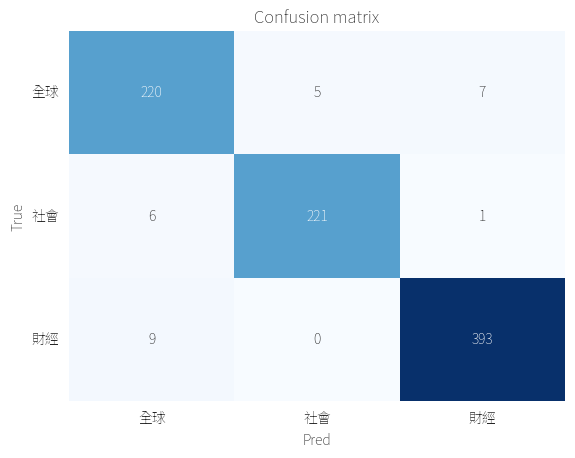

In [185]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [186]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.05162936,
       0.        , 0.        , 0.        , 0.09885165, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0561859 , 0.        , 0.        ,
       0.04975648, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04508522,
       0.        , 0.        , 0.05644981, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05605573, 0.        , 0.        , 0.        ,
       0.        , 0.05241231, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0495902 , 0.        , 0.        , 0.        ,
       0.        , 0.02677613, 0.12012004, 0.05542202, 0.06228163,
       0.        , 0.        , 0.        , 0.        , 0.     

In [187]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.95      0.92      0.94       232
          社會       0.97      0.97      0.97       228
          財經       0.97      0.99      0.98       402

    accuracy                           0.97       862
   macro avg       0.96      0.96      0.96       862
weighted avg       0.97      0.97      0.97       862



In [188]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[214,   8,  10],
       [  5, 222,   1],
       [  6,   0, 396]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '全球'), Text(0, 1.5, '社會'), Text(0, 2.5, '財經')])

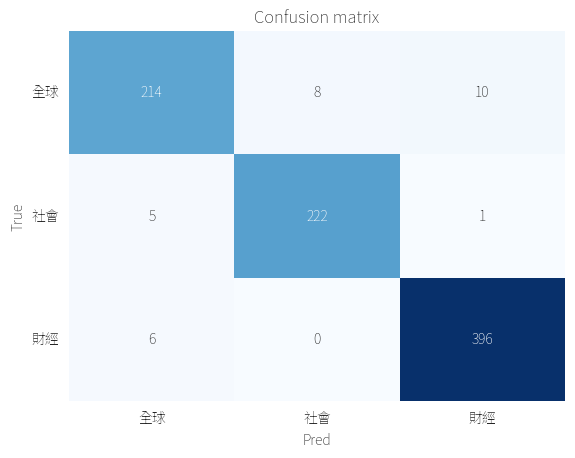

In [189]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

效果一樣也是不錯，可能因為三個新聞版別本來就有很大的差異，用字遣詞會不同。 

### 3.5 CV  

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。 

* figure1:  

![](images/grid_search_workflow.png) 

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [190]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.03399563, 0.03000188, 0.02999997, 0.03100109, 0.03099513]),
 'score_time': array([0.0070045 , 0.00599909, 0.0069952 , 0.00700426, 0.00700021]),
 'test_f1_macro': array([0.97504477, 0.96597168, 0.97184731, 0.96295525, 0.95837677]),
 'test_precision_macro': array([0.97586282, 0.96574407, 0.97085853, 0.97206176, 0.9635227 ]),
 'test_recall_macro': array([0.97424777, 0.96631909, 0.97346507, 0.95650954, 0.95395839])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [191]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          全球       0.97      0.93      0.95       543
          社會       0.97      0.98      0.97       493
          財經       0.97      0.99      0.98       975

    accuracy                           0.97      2011
   macro avg       0.97      0.96      0.97      2011
weighted avg       0.97      0.97      0.97      2011



## 4. 比較不同模型效果

In [192]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          全球       0.97      0.93      0.95       543
          社會       0.97      0.98      0.97       493
          財經       0.97      0.99      0.98       975

    accuracy                           0.97      2011
   macro avg       0.97      0.96      0.97      2011
weighted avg       0.97      0.97      0.97      2011



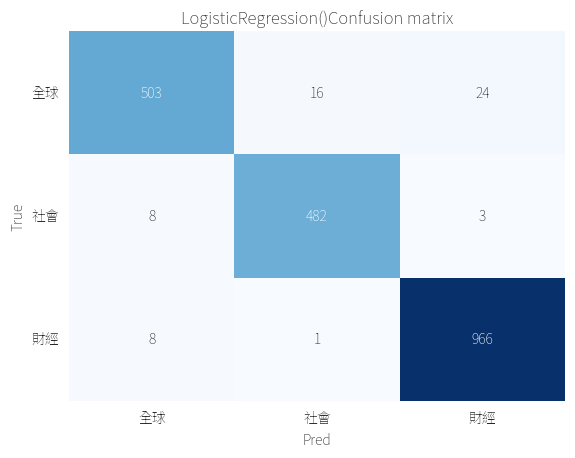

In [193]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          全球       0.97      0.93      0.95       543
          社會       0.97      0.98      0.97       493
          財經       0.97      0.99      0.98       975

    accuracy                           0.97      2011
   macro avg       0.97      0.96      0.97      2011
weighted avg       0.97      0.97      0.97      2011

now training: clf_dtree
              precision    recall  f1-score   support

          全球       0.79      0.80      0.80       543
          社會       0.86      0.86      0.86       493
          財經       0.91      0.91      0.91       975

    accuracy                           0.87      2011
   macro avg       0.85      0.85      0.85      2011
weighted avg       0.87      0.87      0.87      2011

now training: clf_svm
              precision    recall  f1-score   support

          全球       0.96      0.94      0.95       543
          社會       0.97      0.97      0.97       493
  

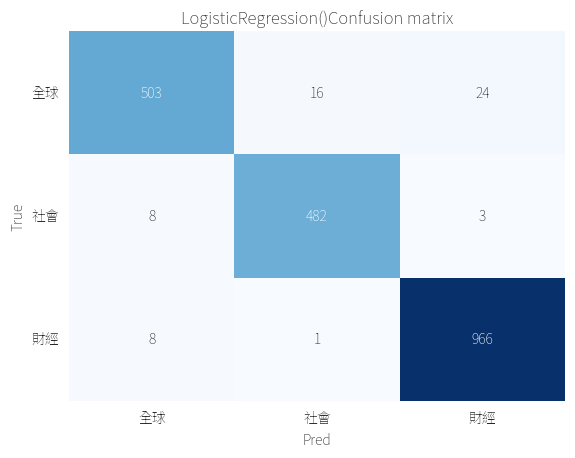

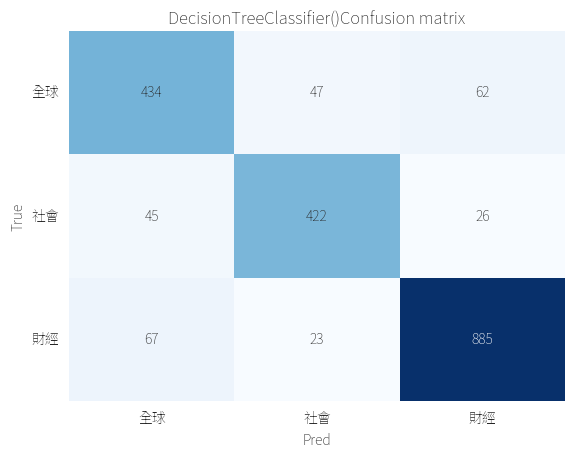

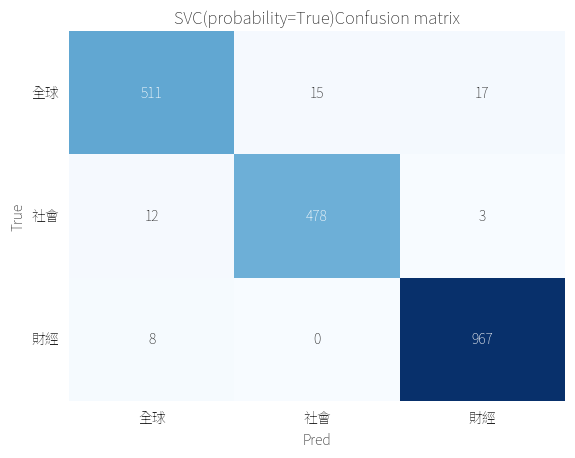

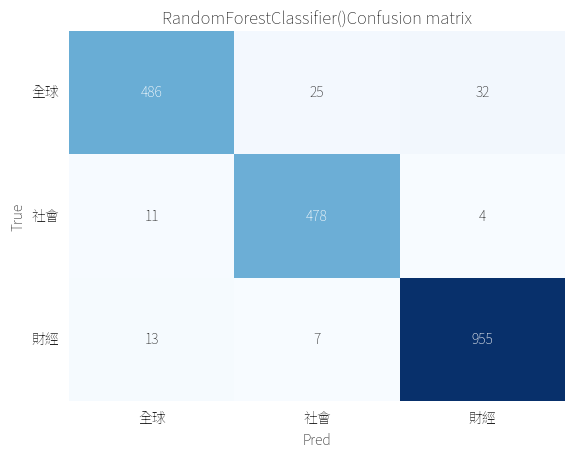

In [194]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [195]:
result_set['clf_logistic']

{'全球': {'precision': 0.9691714836223507,
  'recall': 0.9263351749539595,
  'f1-score': 0.9472693032015066,
  'support': 543.0},
 '社會': {'precision': 0.9659318637274549,
  'recall': 0.9776876267748479,
  'f1-score': 0.9717741935483871,
  'support': 493.0},
 '財經': {'precision': 0.972809667673716,
  'recall': 0.9907692307692307,
  'f1-score': 0.9817073170731707,
  'support': 975.0},
 'accuracy': 0.9701640974639483,
 'macro avg': {'precision': 0.9693043383411739,
  'recall': 0.9649306774993459,
  'f1-score': 0.9669169379410215,
  'support': 2011.0},
 'weighted avg': {'precision': 0.9701411986108626,
  'recall': 0.9701640974639483,
  'f1-score': 0.9699734178041345,
  'support': 2011.0}}

In [196]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.9726504226752859,
 'macro avg': {'f1-score': 0.9689619174697701,
               'precision': 0.970548609521639,
               'recall': 0.9674790160897319,
               'support': 2011.0},
 'weighted avg': {'f1-score': 0.972548545061173,
                  'precision': 0.9725465856256067,
                  'recall': 0.9726504226752859,
                  'support': 2011.0},
 '全球': {'f1-score': 0.9515828677839852,
        'precision': 0.9623352165725048,
        'recall': 0.9410681399631676,
        'support': 543.0},
 '社會': {'f1-score': 0.9695740365111561,
        'precision': 0.9695740365111561,
        'recall': 0.9695740365111561,
        'support': 493.0},
 '財經': {'f1-score': 0.9857288481141692,
        'precision': 0.9797365754812564,
        'recall': 0.9917948717948718,
        'support': 975.0}}


In [197]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.96      0.96      0.96       232
          社會       0.97      0.98      0.98       228
          財經       0.99      0.99      0.99       402

    accuracy                           0.98       862
   macro avg       0.97      0.97      0.97       862
weighted avg       0.98      0.98      0.98       862



In [198]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['全球'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [199]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

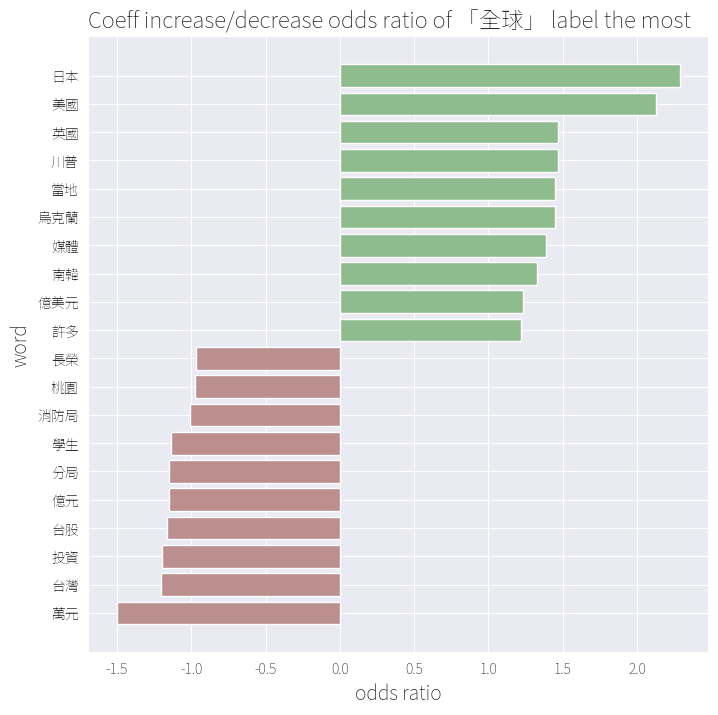

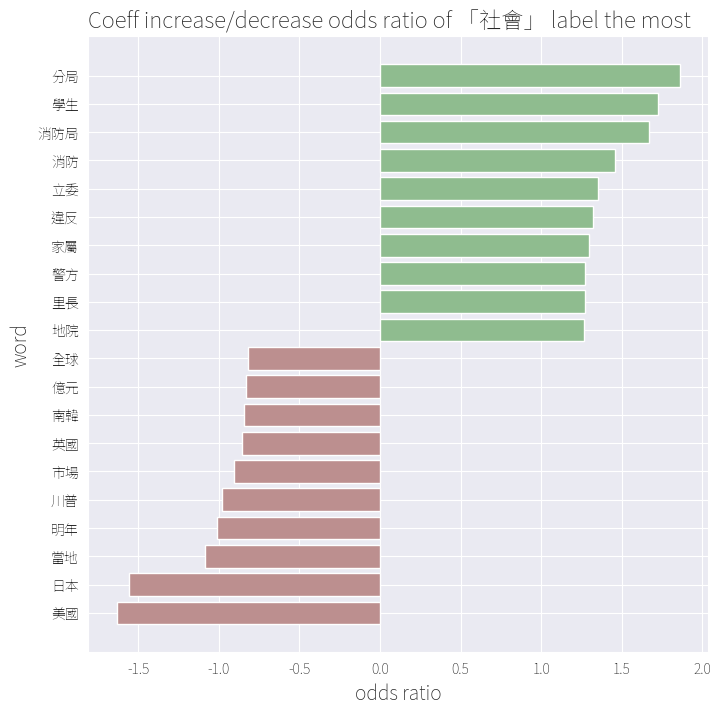

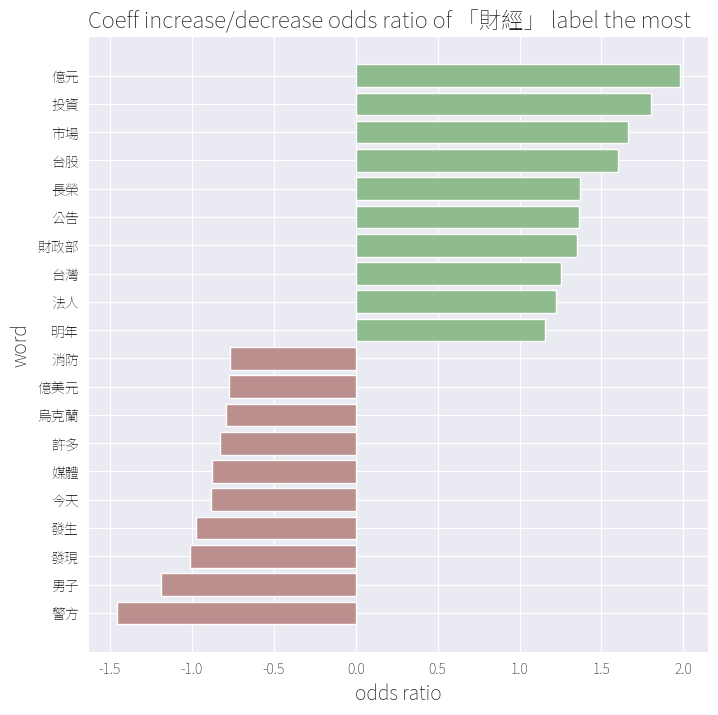

In [200]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

- 「全球」中出現了日本、美國、英國還有當地等國際新聞關鍵字，除了國家名稱外，也提到許多元首名稱，比較特殊的是，"當地"這個詞語也被廣泛使用。
- 「社會」中高係數的字是分局、學生、消防局與消防；「消防」可能與去年選舉前後時有明揚大火導致多名消防人員殉職有關;在許多社會新聞案件中，常提到是由哪些分局處理案件，因此「分局」也是社會新聞常見字彙，而「學生」則是可能與當時的國中生割頸案有關
- 「財經」則是億元、投資、市場與台股等相關詞彙，只會出現在財經相關新聞上。

## 6. 預測新聞類別

`東森新聞.csv` 為東森新聞資料
- 版別：國際(world)、社會(society)、政治(politics)、財經(ec)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無

In [221]:
ct = pd.read_csv("data/東森新聞.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,她勞保多繳4年！少領近57萬 問題竟出在最後3年｜東森新聞,https://news.ebc.net.tw/news/article/397623,2023-12-24 10:59:00,財經,一名擁有26年年資的女性上班族，4年前離職退保，原本一次領可領169.46萬元，後來離職接案，卻選擇加入職業工會，以最低薪資2.5萬元繼續投保，最後少領了近57萬。對此，勞保達人張秘書也做出解釋。YouTube頻道「勞工朋友的祕書～張秘書」在一則影片中分享一個案例，一名52歲勞工年資26年，因職業倦怠不想再朝九晚五，決定改在家接案工作，她雖已符合一次領的資格，卻選擇加入職業工會，加保4年。張秘書以這個例子試算，經過四年的職業工會加保，當小倩決定請領一次給付年金時，卻發現因為最後三年的平均投保薪資僅為2.5萬元，按照勞保局的規定，一次請領的給付金額相對較低，25000元×45個基數＝1125000元。如果小倩當初選擇直接一次請領，擁有26年年資的她可以按照37個基數計算，而最終的給付金額高達169.46萬元，45800元×37個基數＝1694600元。也就是說，小倩勞保多繳4年，反而少領了56萬9600元。張秘書強調，如果勞工選擇一次請領老年給付，務必注意最後3年的投保資薪必須保持在最高水平，否則可能會得不償失。一、必須是離職退保狀態下。二、平均月投保薪資是取最後3年。三、基數算法，前15年一年一個基數，第16年開始每年算二個基數。四、60歲以前年資上限是30年。五、年資未滿30日，以一個月計算。一、保險年資合計每滿1年，按其平均月投保薪資發給1個月。二、保險年資合計超過15年者，超過部分，每滿1年發給2個月，最高以45個月為限。例如：年資26年，其給付年資15+22＝37（個基數）。三、被保險人逾60歲繼續工作者，其逾60歲以後之保險年資，最多以5年計，合併60歲以前之一次請領老年給付，最高以50個月為限。,EBC
1,2,她薪水全丟這！存百萬竟遭18歲表弟嗆：不如阿公那輩｜東森新聞,https://news.ebc.net.tw/news/article/397656,2023-12-24 14:16:00,財經,面對低薪，除了斜槓，大家也會選擇投資。一名女網友表示，才高中的表弟嘲笑她只懂存錢，投資理財的等級比阿公那輩還不如，讓她開始想要改變。原PO在Dcard指出，因為父母沒有投資的習慣，家庭教育也一直跟她反覆告誡投資有風險，股票可能會讓人賠到跳樓，所以長大賺了錢也只會存起來，甚至直到前年才知道一樣是存錢，存到實體開戶的銀行，跟存到數位帳戶利息差很多，所以薪水都是每月固定轉Bankee領利息。原PO透露，親戚聚會的時候聊到理財，才發現現在的高中生都很有想法，也敢於付諸行動，明明還沒出社會賺錢，但賺錢的方法很多，才18歲已經看好要買哪支股票，「表弟問我買股票有沒有賺錢，我說沒有買後，還被他嘲諷，說我只懂存錢，投資理財的等級比阿公那輩還不如，阿公30年前都知道買股票、固定領股息，我這樣根本不算現代人，還是趕快找個有錢男人嫁了。」原PO附上近200萬的存款嘆，平時會逛理財板，看到很多人分享自己千萬存款或幾歲存到百萬，其實覺得很羨慕，也想改變，「2024年開始想要開始投資一點股票，或者多做點副業增加收入，目前已經有申請證券開戶了，不曉得大家有沒有推薦的。」貼文一出，不少人紛紛留言「不會覺得自己比沒買股票的人厲害，任何事情只要想開始都不嫌晚，ETF自己慢慢爬文，投資不要隨意相信他人」、「沒有說存銀行就是不好的投資，投資確實也有風險，不懂理財穩穩存銀行也不吃虧」、「股票也可能賠錢，你這樣列，感覺太理想了」。文章來源：她拿到薪水全丟這⋯「百萬存款」曝光18歲表弟酸：比阿公那輩還不如由CTWANT授權轉載。,EBC
2,3,陽明海運年終落差超嚴重！去年13個月 今年數字嚇死人｜東森新聞,https://news.ebc.net.tw/news/article/397802,2023-12-25 12:13:00,財經,在疫情期間，航運相關產業可以說是獲利頗豐，陽明海運在2022年的年終就高達13個月，羨煞不少民眾。但現在有消息指出，陽明海運於日前召開董事會，決議今年年終獎金僅1個月，加上每年固定的第13個月薪資，形同年終獎金僅2個月，與去年相比有著不少的落差。據了解，陽明海運去年年終有13個月，2023年的年度分紅也有20個月，整個加起來多達33個月之多。但根據媒體報導指出，在陽明海運的董事會上，決議年終獎金僅有1個月。而報導中也推估2024年的年終分紅也僅有1個月，加上固定的第13個月薪資，總和僅3.2個月。但好消息是，陽明海運將比照公務員標準，明年為員工加薪4%。報導中也提到，由於陽明海運具有官股性質，年終獎金最多只能發12個月，但是在分紅制度方面，陽明海運明訂稅前獲利1%為員工紅利，這數字遠高於長榮海運的0.5%與萬海的0.6%。,EBC
3,4,勞保紓困貸款最高拿10萬元 申請4條件曝光！｜東森新聞,https://news.ebc.net.tw/news/article/397804,2023-12-25 13:02:00,財經,勞工快看過來！今（25）日，勞動部公告113年勞保紓困貸款將在1月5日開放申請，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，其也列出貸款申貸資格4條件，若有符合資格的勞工，記得於受理時間申請。勞動部表示，為了要協助勞工朋友度過農曆年前經濟困難，113年勞保紓困貸款將於113年1月5日正式開辦，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，年利率目前為2.04％，前6個月按月付息不還本，第7個月起按月平均攤還本息。1.生活困難需要紓困2.參加勞工保險年資滿15年（計算至受理截止日113年1月19日止）3.無欠繳勞工保險費及滯納金4.未曾借貸勞保紓困貸款，或曾借貸已繳清貸款本金及利息者勞動部指出，若是已請領老年給付、終身無工作能力之失能給付或向其所屬機關請領勞工保險補償金者，則不得申請勞保紓困貸款。申辦本項貸款無需繳交任何費用；每人限申請1次，重複申請者不予受理。另外，符合資格且有需求之勞工朋友，可以於受理申請期間，透過網路、臨櫃或郵寄等方式，向土地銀行各地分行或其委託之金融機構提出申請。對此，勞動部也呼籲，為了減少民眾臨櫃排隊久候時間，請多加利用網路申請，例假日亦可使用，既省時又方便。此外，勞動部勞工保險局在2023年的尾聲，將陸續完成11項給付的入帳作業，預計今日發放國民年金保險老年基本保證年金、國民年金保險原住民給付；周四（28日）則預計發放勞保年金給付、職保年金給付、勞退月退休金（首發案）。周五（29日）將有另外6項給付入帳，包括產檢假與陪產檢及陪產假薪資補助、國保身心障礙年金給付併計勞保年資、國民年金保險老年年金給付、國民年金保險身心障礙（基本保證）年金、國民年金保險喪葬給付、國民年金保險遺囑年金。詳情請治土地銀行客服專線（02）2314-6633及其所屬分行或其委託金融機構，土地銀行於連江縣馬祖地區無營業據點，委託連江縣農會受理；或電洽勞保局服務專線（02）2396-1266。,EBC
4,5,台塑四寶獲利衰！年終3.5個月恐無望 創11年低｜東森新聞,https://news.ebc.net.tw/news/article/397811,2023-12-25 13:51:00,財經,舞台上辣妹勁歌熱舞，炒熱現場氣氛，年底員工最期待的就是年終尾牙，不過傳產龍頭台塑集團，考量剛搬遷到內湖新總部，今年尾牙還是再度停辦，而年終獎金恐怕還會讓員工小失望，因為可能創下近11年最低，不到3.5個月。台塑企業全國聯合會理事長陳鴻儒：「外界所傳的要（EPS）2.43元，（年終）才能達到3.5個月，好在是說公司跟工會有做一個協商，最低保障是3個月，最高7個月。」攤開歷年台塑年終大紅包，110年獲利爆發，員工年終領到最高上限7個月，羨煞不少人，但去年開始受到國際油價、石化行情趨緩影響，略為縮水，而今年可能不只保不了3.5個月，就連工會想積極爭取的3.3個月，恐怕也很艱難。財經專家邱敏寬：「台塑四寶在年底的時候，又遭遇到整個EAFC當中的特殊產品限制，那就目前來說，這個限制到選後會不會開放，要持續來做觀察。」尤其在通膨升息壓力干擾下，讓中國大陸經濟復甦不如預期，即使第三季油價強彈，但台塑四寶前三季稅後純益，仍是452億元年減60.8％，財經專家邱敏寬：「明年的經濟成長率，目前七大機構來估，大概都有到3％以上，今年對台塑四寶相對比較保守，但是我對於明年倒是會比較樂觀一些，因為明年的傳統產業跟電子產業，特別是在通訊跟AI這一塊，擴張性會比較大一點。」不過明年台塑是否將會出現變動，資深媒體人臉書及內部員工，都爆出明年台塑四寶將有人事大地震，但台塑集團對相關謠言皆不予置評，要專注在公司營運，期許在新的一年，能繼續全力衝刺。,EBC
...,...,...,...,...,...,...,...
1775,1776,美英轟葉門叛軍 油價飆漲4％貨櫃運價連7漲｜東森新聞,https://news.ebc.net.tw/news/article/400727,2024-01-13 08:00:00,國際,美英聯軍12日針對葉門叛軍青年運動的73處目標，發射至少一百五十枚「戰斧」巡弋飛彈及雷射導引炸彈。轟炸葉門叛軍青年運動的73處目標。紅海局勢升高，造成貨櫃運價連七漲，原油價格也

In [222]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,她勞保多繳4年！少領近57萬 問題竟出在最後3年｜東森新聞一名擁有26年年資的女性上班族，4年前離職退保，原本一次領可領169.46萬元，後來離職接案，卻選擇加入職業工會，以最低薪資2.5萬元繼續投保，最後少領了近57萬。對此，勞保達人張秘書也做出解釋。YouTube頻道「勞工朋友的祕書～張秘書」在一則影片中分享一個案例，一名52歲勞工年資26年，因職業倦怠不想再朝九晚五，決定改在家接案工作，她雖已符合一次領的資格，卻選擇加入職業工會，加保4年。張秘書以這個例子試算，經過四年的職業工會加保，當小倩決定請領一次給付年金時，卻發現因為最後三年的平均投保薪資僅為2.5萬元，按照勞保局的規定，一次請領的給付金額相對較低，25000元×45個基數＝1125000元。如果小倩當初選擇直接一次請領，擁有26年年資的她可以按照37個基數計算，而最終的給付金額高達169.46萬元，45800元×37個基數＝1694600元。也就是說，小倩勞保多繳4年，反而少領了56萬9600元。張秘書強調，如果勞工選擇一次請領老年給付，務必注意最後3年的投保資薪必須保持在最高水平，否則可能會得不償失。一、必須是離職退保狀態下。二、平均月投保薪資是取最後3年。三、基數算法，前15年一年一個基數，第16年開始每年算二個基數。四、60歲以前年資上限是30年。五、年資未滿30日，以一個月計算。一、保險年資合計每滿1年，按其平均月投保薪資發給1個月。二、保險年資合計超過15年者，超過部分，每滿1年發給2個月，最高以45個月為限。例如：年資26年，其給付年資15+22＝37（個基數）。三、被保險人逾60歲繼續工作者，其逾60歲以後之保險年資，最多以5年計，合併60歲以前之一次請領老年給付，最高以50個月為限。,https://news.ebc.net.tw/news/article/397623,財經,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 年前 離職 退保 原本 一次 領可領 169.46 萬元 離職 接案 選擇 加入 職業工會 最低 薪資 2.5 萬元 繼續 投保 最後 少領 57 對此 勞保 達人 張秘 做出 解釋 YouTube 頻道 勞工 朋友 祕書 張秘書 影片 分享 案例 一名 52 勞工 年資 26 職業倦怠 不想 朝九晚五 決定 在家 接案 工作 符合 一次 領的 資格 選擇 加入 職業工會 加保 秘書以 例子 試算 四年 職業工會 加保 當小倩 決定 請領 一次 給付 年金 發現 最後 三年 平均 投保 薪資 僅為 2.5 萬元 勞保局 規定 一次 請領 給付 金額 相對 25000 45 基數 1125000 小倩 當初 選擇 直接 一次 請領 擁有 26 年資 37 基數 計算 最終 給付 金額 高達 169.46 萬元 45800 37 基數 1694600 也就是說 小倩 勞保 多繳 少領 56 9600 張秘書 強調 勞工 選擇 一次 請領 老年 給付 務必 注意 最後 投保 資薪 保持 最高 水平 得不償失 離職 退保 狀態 平均 投保 薪資 最後 基數 算法 15 一年 基數 16 每年 二個 基數 60 以前 年資 上限 30 年資 未滿 30 一個月 計算 年資 合計 每滿 平均 投保 薪資 發給 年資 合計 超過 15 年者 超過 部分 每滿 發給 最高 45 年資 26 給付 年資 15 22 37 基數 被保險人 60 繼續 工作者 60 以後 年資 最多以 年計 合併 60 以前 一次 請領 老年 給付 最高 50
1,她薪水全丟這！存百萬竟遭18歲表弟嗆：不如阿公那輩｜東森新聞面對低薪，除了斜槓，大家也會選擇投資。一名女網友表示，才高中的表弟嘲笑她只懂存錢，投資理財的等級比阿公那輩還不如，讓她開始想要改變。原PO在Dcard指出，因為父母沒有投資的習慣，家庭教育也一直跟她反覆告誡投資有風險，股票可能會讓人賠到跳樓，所以長大賺了錢也只會存起來，甚至直到前年才知道一樣是存錢，存到實體開戶的銀行，跟存到數位帳戶利息差很多，所以薪水都是每月固定轉Bankee領利息。原PO透露，親戚聚會的時候聊到理財，才發現現在的高中生都很有想法，也敢於付諸行動，明明還沒出社會賺錢，但賺錢的方法很多，才18歲已經看好要買哪支股票，「表弟問我買股票有沒有賺錢，我說沒有買後，還被他嘲諷，說我只懂存錢，投資理財的等級比阿公那輩還不如，阿公30年前都知道買股票、固定領股息，我這樣根本不算現代人，還是趕快找個有錢男人嫁了。」原PO附上近200萬的存款嘆，平時會逛理財板，看到很多人分享自己千萬存款或幾歲存到百萬，其實覺得很羨慕，也想改變，「2024年開始想要開始投資一點股票，或者多做點副業增加收入，目前已經有申請證券開戶了，不曉得大家有沒有推薦的。」貼文一出，不少人紛紛留言「不會覺得自己比沒買股票的人厲害，任何事情只要想開始都不嫌晚，ETF自己慢慢爬文，投資不要隨意相信他人」、「沒有說存銀行就是不好的投資，投資確實也有風險，不懂理財穩穩存銀行也不吃虧」、「股票也可能賠錢，你這樣列，感覺太理想了」。文章來源：她拿到薪水全丟這⋯「百萬存款」曝光18歲表弟酸：比阿公那輩還不如由CTWANT授權轉載。,https://news.ebc.net.tw/news/article/397656,財經,薪水 百萬 18 表弟 阿公 那輩 東森 新聞 面對 低薪 斜槓 選擇 投資 一名 女網友 表示 高中 表弟 嘲笑 存錢 投資 理財 等級 阿公 那輩還 想要 改變 PO Dcard 指出 父母 投資 習慣 家庭教育 一直 反覆 告誡 投資 風險 股票 賠到 跳樓 長大 賺了錢 只會存 直到 前年 知道 存錢 實體 開戶 銀行 存到 數位 帳戶 利息 薪水 每月 固定 Bankee 利息 PO 透露 親戚 聚會 聊到 理財 發現 現在 高中生 想法 付諸行動 明明 還沒出 社會 賺錢 賺錢 方法 18 已經 看好 哪支 股票 表弟 問我 股票 有沒有 賺錢 還被 嘲諷 存錢 投資 理財 等級 阿公 那輩還 阿公 30 年前 知道 股票 固定 股息 根本 不算 現代人 找個 有錢 男人 PO 附上 200 存款 平時 理財 看到 分享 存款 幾歲 百萬 覺得 羨慕 改變 2024 想要 投資 一點 股票 做點 副業 增加收入 目前 已經 申請 證券 開戶 曉得 有沒有 推薦 貼文 一出 紛紛 留言 覺得 股票 厲害 事情 ETF 慢慢 爬文 投資 隨意 相信 說存 銀行 不好 投資 投資 確實 風險 理財 穩穩 銀行 吃虧 股票 賠錢 感覺 理想 文章 來源 拿到 薪水 百萬 存款 曝光 18 表弟 阿公 那輩還 CTWANT 授權 轉載
2,陽明海運年終落差超嚴重！去年13個月 今年數字嚇死人｜東森新聞在疫情期間，航運相關產業可以說是獲利頗豐，陽明海運在2022年的年終就高達13個月，羨煞不少民眾。但現在有消息指出，陽明海運於日前召開董事會，決議今年年終獎金僅1個月，加上每年固定的第13個月薪資，形同年終獎金僅2個月，與去年相比有著不少的落差。據了解，陽明海運去年年終有13個月，2023年的年度分紅也有20個月，整個加起來多達33個月之多。但根據媒體報導指出，在陽明海運的董事會上，決議年終獎金僅有1個月。而報導中也推估2024年的年終分紅也僅有1個月，加上固定的第13個月薪資，總和僅3.2個月。但好消息是，陽明海運將比照公務員標準，明年為員工加薪4%。報導中也提到，由於陽明海運具有官股性質，年終獎金最多只能發12個月，但是在分紅制度方面，陽明海運明訂稅前獲利1%為員工紅利，這數字遠高於長榮海運的0.5%與萬海的0.6%。,https://news.ebc.net.tw/news/article/397802,財經,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 相關 產業 獲利 頗豐 陽明 海運 2022 年終 高達 13 羨煞 民眾 現在 消息 指出 陽明 海運 日前 召開 董事會 決議 今年 年終獎金 每年 固定 13 薪資 形同 年終獎金 去年 相比 有著 落差 了解 陽明 海運 去年 年終 13 2023 年度 分紅 20 整個 多達 33 媒體 指出 陽明 海運 董事會 決議 年終獎金 僅有 推估 2024 年終 分紅 僅有 固定 13 薪資 總和 3.2 好消息 陽明 海運 公務員 標準 明年 員工 加薪 4% 提到 陽明 海運 具有 官股 性質 年終獎金 只能 12 分紅 制度 方面 陽明 海運 明訂 稅前 獲利 1% 員工 紅利 數字 遠高於 長榮 海運 0.5% 萬海 0.6%
3,勞保紓困貸款最高拿10萬元 申請4條件曝光！｜東森新聞勞工快看過來！今（25）日，勞動部公告113年勞保紓困貸款將在1月5日開放申請，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，其也列出貸款申貸資格4條件，若有符合資格的勞工，記得於受理時間申請。勞動部表示，為了要協助勞工朋友度過農曆年前經濟困難，113年勞保紓困貸款將於113年1月5日正式開辦，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，年利率目前為2.04％，前6個月按月付息不還本，第7個月起按月平均攤還本息。1.生活困難需要紓困2.參加勞工保險年資滿15年（計算至受理截止日113年1月19日止）3.無欠繳勞工保險費及滯納金4.未曾借貸勞保紓困

In [223]:
ct['artCatagory'].value_counts()

artCatagory
政治    660
社會    622
國際    451
財經     47
Name: count, dtype: int64

In [224]:
mapper = {"政治":"社會", "國際":"全球", "社會":"社會", "財經":"財經"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          全球       0.57      0.88      0.69       451
          社會       0.95      0.75      0.84      1282
          財經       0.39      0.64      0.48        47

    accuracy                           0.78      1780
   macro avg       0.64      0.76      0.67      1780
weighted avg       0.84      0.78      0.79      1780



In [232]:
classes = clf.classes_
cm = confusion_matrix(y, y_pred)
cm

array([[397,  46,   8],
       [283, 960,  39],
       [ 15,   2,  30]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '全球'), Text(0, 1.5, '社會'), Text(0, 2.5, '財經')])

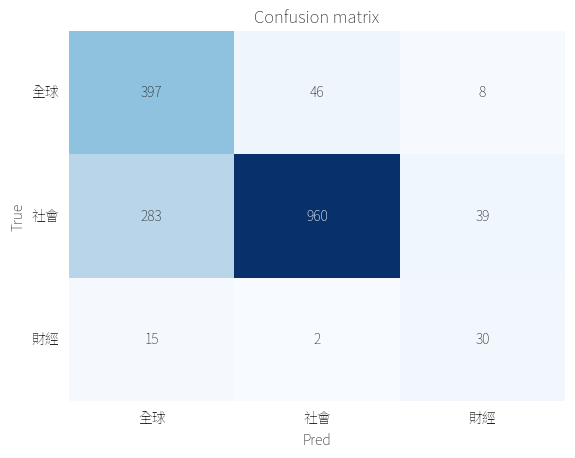

In [235]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [225]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 年前 離職 退保 原本 一次 領可領 169.46 萬元 離職 接案 選擇 加入 職業工會 最低 薪資 2.5 萬元 繼續 投保 最後 少領 57 對此 勞保 達人 張秘 做出 解釋 YouTube 頻道 勞工 朋友 祕書 張秘書 影片 分享 案例 一名 52 勞工 年資 26 職業倦怠 不想 朝九晚五 決定 在家 接案 工作 符合 一次 領的 資格 選擇 加入 職業工會 加保 秘書以 例子 試算 四年 職業工會 加保 當小倩 決定 請領 一次 給付 年金 發現 最後 三年 平均 投保 薪資 僅為 2.5 萬元 勞保局 規定 一次 請領 給付 金額 相對 25000 45 基數 1125000 小倩 當初 選擇 直接 一次 請領 擁有 26 年資 37 基數 計算 最終 給付 金額 高達 169.46 萬元 45800 37 基數 1694600 也就是說 小倩 勞保 多繳 少領 56 9600 張秘書 強調 勞工 選擇 一次 請領 老年 給付 務必 注意 最後 投保 資薪 保持 最高 水平 得不償失 離職 退保 狀態 平均 投保 薪資 最後 基數 算法 15 一年 基數 16 每年 二個 基數 60 以前 年資 上限 30 年資 未滿 30 一個月 計算 年資 合計 每滿 平均 投保 薪資 發給 年資 合計 超過 15 年者 超過 部分 每滿 發給 最高 45 年資 26 給付 年資 15 22 37 基數 被保險人 60 繼續 工作者 60 以後 年資 最多以 年計 合併 60 以前 一次 請領 老年 給付 最高 50,財經,全球
1,薪水 百萬 18 表弟 阿公 那輩 東森 新聞 面對 低薪 斜槓 選擇 投資 一名 女網友 表示 高中 表弟 嘲笑 存錢 投資 理財 等級 阿公 那輩還 想要 改變 PO Dcard 指出 父母 投資 習慣 家庭教育 一直 反覆 告誡 投資 風險 股票 賠到 跳樓 長大 賺了錢 只會存 直到 前年 知道 存錢 實體 開戶 銀行 存到 數位 帳戶 利息 薪水 每月 固定 Bankee 利息 PO 透露 親戚 聚會 聊到 理財 發現 現在 高中生 想法 付諸行動 明明 還沒出 社會 賺錢 賺錢 方法 18 已經 看好 哪支 股票 表弟 問我 股票 有沒有 賺錢 還被 嘲諷 存錢 投資 理財 等級 阿公 那輩還 阿公 30 年前 知道 股票 固定 股息 根本 不算 現代人 找個 有錢 男人 PO 附上 200 存款 平時 理財 看到 分享 存款 幾歲 百萬 覺得 羨慕 改變 2024 想要 投資 一點 股票 做點 副業 增加收入 目前 已經 申請 證券 開戶 曉得 有沒有 推薦 貼文 一出 紛紛 留言 覺得 股票 厲害 事情 ETF 慢慢 爬文 投資 隨意 相信 說存 銀行 不好 投資 投資 確實 風險 理財 穩穩 銀行 吃虧 股票 賠錢 感覺 理想 文章 來源 拿到 薪水 百萬 存款 曝光 18 表弟 阿公 那輩還 CTWANT 授權 轉載,財經,財經
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 相關 產業 獲利 頗豐 陽明 海運 2022 年終 高達 13 羨煞 民眾 現在 消息 指出 陽明 海運 日前 召開 董事會 決議 今年 年終獎金 每年 固定 13 薪資 形同 年終獎金 去年 相比 有著 落差 了解 陽明 海運 去年 年終 13 2023 年度 分紅 20 整個 多達 33 媒體 指出 陽明 海運 董事會 決議 年終獎金 僅有 推估 2024 年終 分紅 僅有 固定 13 薪資 總和 3.2 好消息 陽明 海運 公務員 標準 明年 員工 加薪 4% 提到 陽明 海運 具有 官股 性質 年終獎金 只能 12 分紅 制度 方面 陽明 海運 明訂 稅前 獲利 1% 員工 紅利 數字 遠高於 長榮 海運 0.5% 萬海 0.6%,財經,財經
3,勞保 貸款 最高 10 萬元 申請 條件 曝光 東森 新聞 勞工 過來 25 勞動部 公告 113 勞保 貸款 將在 開放 申請 受理 113 19 截止 每人 最高 可貸 10 萬元 貸款 期間 列出 貸款 申貸 資格 條件 若有 符合 資格 勞工 記得 受理 時間 申請 勞動部 表示 協助 勞工 朋友 度過 農曆 年前 經濟 困難 113 勞保 貸款 將於 113 正式 開辦 受理 113 19 截止 每人 最高 可貸 10 萬元 貸款 期間 年利率 目前 2.04 付息 還本 平均 攤還 本息 生活 困難 需要 參加 勞工保險 年資 15 計算 受理 截止日 113 19 日止 欠繳 勞工 保險費 滯納金 未曾 借貸 勞保 貸款 借貸 繳清 貸款 本金 利息 勞動部 指出 請領 老年 給付 終身 工作 能力 之失 給付 所屬 機關 請領 勞工保險 補償金 申請 勞保 貸款 申辦 本項 貸款 無需 繳交 費用 每人 申請 重複 申請者 不予 受理 符合 資格 需求 勞工 朋友 受理 申請 期間 透過 網路 臨櫃 郵寄 方式 土地銀行 各地 分行 委託 金融機構 提出申請 對此 勞動部 呼籲 減少 民眾 臨櫃 排隊 久候 時間 請多加 利用 網路 申請 例假日 亦可 使用 既省 方便 勞動部 勞工保險 局在 2023 尾聲 陸續 完成 11 給付 入帳 作業 預計 今日 發放 國民 年金 老年 保證 年金 國民 年金 原住民 給付 周四 28 預計 發放 勞保 年金 給付 職保 年金 給付 勞退 退休金 首發 周五 29 將有 給付 入帳 包括 產檢假 陪產 檢及 產假 薪資 補助 國保 身心 障礙 年金 給付 勞保 年資 國民 年金 老年 年金 給付 國民 年金 身心 障礙 保證 年金 國民 年金 喪葬 給付 國民 年金 遺囑 年金 詳情請 土地銀行 客服 專線 02 2314 6633 所屬 分行 委託 金融機構 土地銀行 連江縣 馬祖地區 營業 據點 委託 連江縣 農會 受理 電洽 勞保局 服務 專線 02 2396 1266,財經,財經
4,台塑 四寶 獲利 年終 3.5 無望 11 東森 新聞 舞台 辣妹 勁歌熱舞 炒熱 現場 氣氛 年底 員工 期待 年終 尾牙 傳產 龍頭 台塑 集團 考量 搬遷 內湖 總部 今年 尾牙 再度 停辦 年終獎金 還會 員工 失望 創下 11 最低 不到 3.5 台塑 企業 全國 聯合會 理事長 鴻儒 外界 所傳 EPS 2.43 年終 達到 3.5 公司 工會 協商 最低 保障 最高 攤開 歷年 台塑 年終 大紅包 110 獲利 爆發 員工 年終 領到 最高 上限 羨煞 去年 受到 國際 油價 石化 行情 趨緩 影響 縮水 今年 3.5 就連 工會 積極爭取 3.3 艱難 財經專家 邱敏 台塑 四寶在 年底 遭遇 整個 EAFC 特殊 產品 限制 目前 來說 限制 選後會 開放 持續 觀察 尤其 升息 壓力 干擾 中國 大陸 經濟 復甦 預期 第三季 油價 強彈 台塑 四寶 前三季 稅後 純益 452 億元 年減 60.8 財經專家 邱敏 明年 經濟 成長率 目前 七大 機構 來估 以上 今年 台塑 四寶 相對 比較 保守 明年 比較 樂觀 一些 明年 傳統產業 電子 產業 特別是在 通訊 AI 一塊 擴張性 比較 一點 明年 台塑 是否 將會 出現 變動 資深 媒體 人臉 書及 內部 員工 爆出 明年 台塑 四寶將 有人 事大 地震 台塑 集團 相關 謠言 不予置評 專注 公司 營運 期許 一年 繼續 衝刺,財經,財經
...,...,...,...
1775,美英 葉門 叛軍 油價 飆漲 貨櫃 運價 東森 新聞 美英 聯軍 12 針對 葉門 叛軍 青年運動 73 目標 發射 至少 一百五十 戰斧 巡弋 飛彈 雷射 導引 炸彈 轟炸 葉門 叛軍 青年運動 73 目標 紅海 局勢 升高 造成 貨櫃 運價 連七漲 原油價格 一天 飆漲 4% 夜色 美軍 F18 戰機 艾森豪 航空母艦 升空 打擊 葉門 叛軍 青年運動 據點 英國 颱風 戰機 塞普路斯 起飛 進行 攻擊 參與 軍事行動 協力 國家 包括 澳洲 巴林 加拿大 荷蘭 美國國防部 發言人 萊德 這是 國際 問題 需要 國際 社會 共同 解決 當地 時間 12 凌晨 英美 聯軍 發射 包括 戰斧 飛彈 超過 一百五十 精準 導引 彈藥 攻擊 伊朗 支持 青年運動 叛軍 葉門 首都 地點 73 目標 目的 削弱 青年運動 去年底 以來 宣稱 支持 薩哈 瑪斯 紅海 商船 攻擊 武力 美國 總統 拜登 我己 經向 伊朗 傳遞 訊息 知道 所欲 拜登 表示 伊朗 代理人 戰爭 對此 青年運動 進行 反擊 至少 發射 飛彈 擊中 船艦 青年運動 揚言 繼續 攻擊 紅海 商船 首都 那則 出現 大規模 反美 以色列 抗議 數萬人 湧上 首都 街頭 遊行 焚燒 國旗 洩憤 伊朗 公布 11 號在 阿曼灣 扣押 一艘 美國 油輪 畫面 伊朗 表示 這項 行動 報復 美國 去年 扣押 一艘船 石油 紅海 局勢 升溫 造成 油價 波動 布蘭特 北海 原油 西德 中級 原油 十二日 價格 飆漲 貨櫃 運價 指數 攀高 最新 一期 上海 出口 集裝箱 運價 指數 大漲 309.38 點至 2206.03 站上 2000 大關 英美 聯軍 攻擊 葉門 叛軍 引發 疑慮 卡達 阿曼 美國 波斯灣 盟邦 擔憂 

In [226]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
0,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 年前 離職 退保 原本 一次 領可領 169.46 萬元 離職 接案 選擇 加入 職業工會 最低 薪資 2.5 萬元 繼續 投保 最後 少領 57 對此 勞保 達人 張秘 做出 解釋 YouTube 頻道 勞工 朋友 祕書 張秘書 影片 分享 案例 一名 52 勞工 年資 26 職業倦怠 不想 朝九晚五 決定 在家 接案 工作 符合 一次 領的 資格 選擇 加入 職業工會 加保 秘書以 例子 試算 四年 職業工會 加保 當小倩 決定 請領 一次 給付 年金 發現 最後 三年 平均 投保 薪資 僅為 2.5 萬元 勞保局 規定 一次 請領 給付 金額 相對 25000 45 基數 1125000 小倩 當初 選擇 直接 一次 請領 擁有 26 年資 37 基數 計算 最終 給付 金額 高達 169.46 萬元 45800 37 基數 1694600 也就是說 小倩 勞保 多繳 少領 56 9600 張秘書 強調 勞工 選擇 一次 請領 老年 給付 務必 注意 最後 投保 資薪 保持 最高 水平 得不償失 離職 退保 狀態 平均 投保 薪資 最後 基數 算法 15 一年 基數 16 每年 二個 基數 60 以前 年資 上限 30 年資 未滿 30 一個月 計算 年資 合計 每滿 平均 投保 薪資 發給 年資 合計 超過 15 年者 超過 部分 每滿 發給 最高 45 年資 26 給付 年資 15 22 37 基數 被保險人 60 繼續 工作者 60 以後 年資 最多以 年計 合併 60 以前 一次 請領 老年 給付 最高 50,財經,全球
5,元老 振榮 辭世 業界 緬懷 生前 海派 人緣 東森 新聞 中鋼前 總經理 振榮 參與 公司 階段 擴建 歷程 業界 享有 聲譽 晚年 飽受 癌症 摧殘 住進 安寧 病房 25 凌晨 辭世 享壽 77 令人 不勝唏噓 振榮 出生 高雄 鳳山 礦冶 畢業 考進 中鋼 出身 政治 世家 叔叔 義秋 外號 鳳山 政商 實力雄厚 政治 一途 1990 年代 擔任 總經理 中鋼 黃埔 一期 員工 基層 做起 一晃眼 12 民營化 過程 人脈 帶領 團隊 立法院 朝野 溝通 中鋼 國營 轉為 民營 慢慢 奠定 基礎 成為 台灣 最大 鋼鐵企業 振榮 傳出 病逝 各界 紛紛 緬懷 幹部 口吃 喝酒 我弟 豪邁 性格 印象 深刻 稱讚 對方 性情中人 喜歡 交朋友 公司 公關 經他 之手 順遂 公司 基層 親切 幹部 嚴格 幹部 以身作則 鋼鐵 回憶 振榮 當年 帶領 民營化 難能可貴 創造 時代 交棒給 下一代 翁朝棟 帶領 創下 建廠 50 年來 最高 營運 獲利 績效 振榮 退休 每次 提到 此事 有榮 傑出 幹部 拍胸脯 大聲 振榮 永遠 長官 文章 來源 中鋼前 總座 振榮 辭世 享壽 77 業界 緬懷 生前 海派 人緣 CTWANT 授權 轉載,財經,全球
10,美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 政府 選擇 否決 專利 侵權 裁定 蘋果公司 Apple 今天 表示 旗下 智慧 手錶 AppleWatch 最新型 號的 進口 禁令 提起 上訴 綜合 法新社 路透社 這項 針對 蘋果 最新 智慧 手錶 型號 禁令 今天 生效 AppleWatchSeries9 AppleWatchUltra2 無法 美國 實體 商店 或線 銷售 這項 禁令 大型 科技 公司 具有 價值 專利 展開 最新 法律 角力 谷歌 Google 針對 揚聲器 技術 Sonos 打官司 美國 國際貿易 委員會 ITC 10 裁定 禁止 進口 侵犯 一項 測定 血氧 含量 專利技術 蘋果 智慧 手錶 型號 這項 禁令 源起 Masimo 公司 2021 ITC 提出 申訴 這家 醫療 設備 製造商 指控 蘋果 侵犯 公司 感測 技術 測量 血氧 含量 專利 Masimo 這項 技術 發明 蘋果 挖角 員工 取得 技術 美國 貿易 代表 USTR 今天 聲明 指出 謹慎 商議 貿易 代表 戴琪 KatherineTai 決定 撤銷 ITC 這項 裁定 ITC 決定 2023 12 26 日成 最終 裁定 白宮 有權 撤銷 進口 禁令 狀況 鮮少 發生 蘋果 主張 ITC 裁決 錯誤 應予 撤銷 並向 美國聯邦 法院 提起 上訴 蘋果 發言人 表示 公司 針對 這項 禁令 華盛頓 美國聯邦 巡迴 上訴 法院 CourtofAppealsfortheFederalCircuit 提起 上訴 蘋果 今天 聲明 中說 強烈 同意 ITC 裁定 由此 產生 排除 命令 採取 措施 盡快 美國 顧客 恢復 供應 AppleWatchSeries9 AppleWatchUltra2 蘋果 請求 聯邦 巡迴 上訴 法院 暫停 禁令 至少 暫停 美國 海關 邊境 保護局 CBP 判定 重新 設計 過的 蘋果 智慧 手錶 型號 是否 侵犯 Masimo 專利 並在 法院 考慮 蘋果 請求 暫停 禁令 蘋果 美國 海關 邊境 保護局 預定 明年 12 做出 決定 耶誕 假期 前夕 蘋果 本月 21 已將 產品 自線 蘋果 商店 AppleStore 下架 實體 零售 商店 24 停止 販售,財經,全球
13,東南亞 旅遊 注意 星馬 元旦 將調 消費稅 東森 新聞 打算 東南亞 旅遊 民眾 注意 新加坡 將從 元旦 上調 消費稅 百分點 9% 因應 老齡化 人口 激增 醫療保健 成本 上漲 馬來西亞 將從 明年 銷售 服務 稅調 高到 8% 元旦假期 就要 民眾 規劃 出國 過去 東南亞 國家 注意 明年 元旦 新加坡 將把 商品 服務 稅率 8% 調升 9% 星國 穩定 增稅 擴大 財政 基礎 因應 醫療 照護 成本 高漲 馬來西亞 稅收 東南亞 國家 居後段 將從 明年 銷售 服務 調高 百分點 8% 糧食 飲料 通訊 必要 支出 不在 調升 範圍 各國 國際航班 持續 恢復 目前 中國 官方 發布 最新 數據 預估 元旦 期間 日均 出入境 旅客 達到 156 萬人次 2023 元旦 增長 超過 五倍 回到 2019 九成 水平,財經,全球
16,聯亞 生技 負責人 王長 怡傳 跳票 集團 財務狀況 引熱議 東森 新聞 聯亞 生技 集團 經營權 爭奪 多時 現任 負責人 王長 女兒 胡世一指 無權 擔任 董事長 一職 母女 分裂 派並 爆發 多起 訴訟 傳出 聯亞 生技 集團 王長 掌控 相關 公司 積欠 貨款 遭向 法院 聲請 支付 命令 追討 傳出 王長 財務 出現 狀況 跳票 聯亞生 技是 國發 基金 投資 項目 負責人 財務 未處理 影響 公司 營運 影響 廣大 納稅人 權益 週刊 調查 依據 今年 台灣 票據交換 所票 查詢 記錄 今年 11 28 王長 一筆 退票 日期 今年 10 18 金額 200 萬元 退票 紀錄 退票 理由 存款 不足 清償 贖回 日期 今年 10 27 王長 投資 有限公司 筆的 退票 紀錄 總金額 120 萬元 分別 今年 13 一張 票面額 1000 萬元 12 張支 票面額 分別 20 萬元 50 萬元 50 萬元 退票 理由 存款 不足 清償 日期 空白 週刊 調查 今年 新竹 地院 收到 聯亞 生技 集團 聯合 生物製藥 公司 追債 案件 分別 請求 給付 貨款 支付 命令 給付 價金 案件 金額 萬餘元 百萬元 不等 至今 10 部分 案件 陸續 和解 收到 款項 金額 法院 解決 傳出 王長 跳票 聯亞 生技 集團 財務狀況 相關 廠商 發熱 更多鏡 週刊 王長 胡世一 母女 鬧翻 聯亞 生技 經營權 持續 爭訟 聯亞 母女 紛爭 再起 兩派 發聲明 捍衛 立場 凍結 員工 薪資 羅生門 聯亞 女兒 反控 王長 說謊,財經,社會
...,...,...,...
1752,東京 旅館 挾持 持刀 扣押 人質 與警 對峙 小時 投降 東森 新聞 朝日 電視 記者 20 分鐘 11 25 左右 警視廳 涉嫌 禁閉 嫌犯 現行犯 逮捕 藍色 塑膠 一輛 載著 嫌犯 的車 出現 旅館 坐在 警車 後座 深色 外套 遮住 男子 涉嫌 挾持 人質 嫌犯 事情 發生 日本 東京都 東區 JR 鶯谷 車站 附近 2024 總統 立委 大選 選舉 一覽 線上 12 上午 點多 一間 旅館 員工 報警 一間 客房 傳出 男女 激烈 爭吵 聲音 男方 疑似 持有 刀械 警方 獲報 趕到 現場 房間 裡的 男子 把門 反鎖 女子 當成 人質 不肯 開門 房間 警方 對峙 旅館 周圍 還拉起 封鎖線 10 多名 警察 待命 氣氛 一度 緊張 警方 持續 勸說 之下 雙方 僵持 小時 男子 終於 女子 釋放 女子 意識 清楚 受傷 警方 涉嫌 禁閉 男子 拘留 逮捕 目前 還要 調查 確切 挾持 原因,全球,社會
1756,命喪 柬埔寨 遺體 腫脹 陳屍 公寓 房間 搜出 白粉 東森 新聞 柬埔寨 首都 金邊 天空 公寓 11 發生 一宗 死亡 案件 一名 40 台灣 男子 發現 屍在 房間內 全身 已經 明顯 腫脹 警方 調查過程 男子 住處 搜出 疑似 毒品 白色 粉末 柬中 時報 死者 一名 台灣 40 莊姓 男子 ChuangYiZe 旅遊 簽證 入境 柬埔寨 11 下午 30 金邊 雷西 郊區 天空 SkyTree 公寓 房間 裡被 發現

# 看錯誤預測的社會樣本

In [236]:
false_pred.loc[false_pred['artCatagory']=='社會', :].head(50)

,words,artCatagory,pred
49,緊抓 批賴 冷柯 策略 趙少康 轟賴 工寮 綠能 火力 東森 新聞 總統 政見發表 趙少康 一上台 似乎 同場 兩個 對手 開局 民進黨 總統 候選人 賴清德 國民黨 總統 候選人 趙少康 房屋 房屋 根本 登記 房屋 根本 合法 房屋 面積 755 平方公尺 等於 228 地方 這是 工寮 萬里 老家 捲入 爭議 賴清德 主動 20 號的 政見會 承諾 整棟 房子 交付 公益 信託 礦工 生活 紀念館 趙少康 痛批 這根 本是顆 大型 煙霧彈 國民黨 總統 候選人 趙少康 工寮 三大騙 第一 大騙 礦區 完成 居住權 手續 以後 整個 礦區 居住權 通通 完成 你講 三年 完成 公益 信託 公益 信託 公益 信託 受益人 董事 辭職書 辭職書 簽名 賴清德 決定 投給 2024 大選 命定 總統 立即 一下 再度 搬出 董事長 辭職書 要賴 清德 直球 對決 第二輪 談到 能源 政策 話鋒一轉 繼續 民進黨 能源 政策 國民黨 總統 候選人 趙少康 以前 反核 以前 2025 所謂 能源 政策 徹底 失敗 政策 台電 去年 多少錢 知道 台電 去年 千億 中油 多少錢 知道 中油 去年 千億 天然氣 今年 中油 還要 幾千 台電 還要 幾千 這都 民脂民膏 拿來 不好 錯誤 政策 貪汙 可怕 最好 例子 最好 明證 明明 總統 政見發表 趙少康 整場 指賴 清德 知道 白綠 兩名 副手 心理 作何 感想,社會,財經
50,副手 唯一 政見會 思緒 清晰 表現 最好 東森 新聞 22 晚間 政見會 結束 國民黨 總統 候選人 侯友宜 書上 搭檔 趙少康 照片 附上 顧好 台灣 好康 字樣 內文 寫下 趙少康 思緒 清晰 辯才無礙 整場 發言 金句 表現 最好 一位 看得出 侯友宜 真的 趙少康 表現 十分 肯定 中途 趙少康 口誤 心目 掃黑 英雄 侯友宜 講成 賴清德 決定 投給 2024 大選 命定 總統 立即 一下 趙少康 會後 受訪 隨即 更正 第一 時間 侯友宜 臉書 留言 謝謝 友宜兄 肯定 當選 一定 最好 總統 一起 顧台灣 好康 距離 大選 20 多天 侯康 兩人 搭檔 整場 選戰 最後 衝刺,社會,全球
51,民調 總統 政見會 最新 支持 出爐 侯康 緊追 賴蕭 東森 新聞 美麗 電子報 23 公布 最新 民調 賴蕭配 支持 37.5 35 40 之間 徘徊 侯康配 32.6 緊咬 差距 僅有 4.9 百分點 不斷 緊追 賴蕭配 一直 無發將 差距 拉開 以外 柯盈 配則 持續 墊底 支持 16.3 相較 昨天 公布 95 民調 支持 度上 賴蕭配 侯康配 無太大 變化 柯盈 配則 下探 近期 新低 超過 一個月 超過 支持 明年 總統 是否 換黨 賴蕭配 侯康配 維持 僅小 差距 柯盈 配則 繼續 墊底 僅有 14.2 支持 換成 民眾 政黨 輪替 投給 在野黨 民調 最高者 一問 認同 下降 47.9 支持 在野黨 支持 最高 侯康配 決定 投給 2024 大選 命定 總統 立即 一下 美麗 電子報 民調 2023 17 持續 明年 12 連續 日為 2024 年則 連續 日為 追蹤調查 這次 調查 時間 12 20 日至 22 追蹤 民調 96 民調 全市 抽樣 設計 採用 中華電信 住宅 電話簿 基礎 電腦 資料庫 採用 比分 隨機抽樣 設計 確保 登錄 電話 門號 家戶 能夠 納入 調查 抽取 電話 門號 透過 CATI 系統 主機 派發 號碼 進行 隨機 跳號 處理 替換 撥打 電話 門號 此次 調查 成功 完訪 1470 抽樣誤差 最大值 信賴 水準 95 時為 2.6,社會,全球
54,顧好 台灣 趙少康 韓國 站台 拜票 東森 新聞 國民黨 總統 候選人 趙少康 來到 台中 立委 候選人 江啟 站台 進場 場內 鄉親 熱情 趙少康 站台 台中大 家長 盧秀燕 連許淑華 韓國 前高雄 市長 韓國 餐廳 裡面 道菜 滿漢全席 男人 鼻子 女子 嘴巴 鼻樑 英挺 代表 將來 人中之龍 曉得 有沒有 厲害 一下 江啟 太太 好不好 看到 才華 決定 投給 2024 大選 命定 總統 立即 一下 韓國 誇起 江啟 從政 能力 一路 誇到 外表 趙少康 則是 語出驚人 國民黨 總統 候選人 趙少康 昨天晚上 我講 江啟 台灣 和平 恐怖份子 一點 誇張 賴清德 恐怖份子 江啟 東勢 最好 委員 山神 保護神 對抗 恐怖份子 趙少康 一時 口誤 嚇壞 在場 所有人 藍營 政治 明星 通通 台灣 顧好 對手 綠營 所說 中台灣 對手 侯友宜 盧秀燕 市長 盧秀燕 對手 應該 中部 地區 700 選民 民進黨 執政 重南 輕北 中部 捷運 包括 台中市 包括 未來 延伸 南投 現在 鬆口 要給 捷運 盧秀燕 認為 中部 選民 執政黨 失望 地方 人士 指出 一直 台灣 搖擺 勝負 預料 這次 總統大選 藍綠 雙方 勤跑 台灣 打出 決戰 中台灣 口號 想要 中彰 投苗 拿下 關鍵 一席,社會,全球
58,韓國 問江 啟臣 鼻子 厲害 江妻 才華 東森 新聞 民進黨 總統 候選人 賴清德 搶攻 中台灣 身為 藍營 母雞 市長 盧秀燕 固守 中部 藍營 小雞 江啟 站台 這場 造勢 出動 國民黨 母雞 盧秀燕 分區 第一名 韓國 韓國 上場 金句 連發 引起 現場 笑聲 不斷 國民黨 分區 韓國 有的點 薑絲 大腸 有的點 梅干 扣肉 一下 客家 小炒 發現 江啟 代表 豐原 東勢 餐廳 裡面 一道 滿漢全席 好多 客家菜 市長 國民黨 分區 龍頭 韓國 立委 江啟 站台 菜色 形容 江啟 滿滿 一桌 大菜 外貌 誇讚 五官 過人之處 國民黨 分區 韓國 王淺秋 突然 提醒 市長 有沒有 發現 江啟 委員 鼻子 特別 男人 鼻子 女人 嘴巴 江啟 有點 尷尬 韓國 靈魂 拷問 決定 投給 2024 大選 命定 總統 立即 一下 國民黨 分區 韓國 vs 江啟 妻子 我講 這是 王淺秋用 女性 敏銳 觀察力 看出 江啟 鼻子 很大 哇江 啟臣 人中之龍 曉得 有沒有 厲害 我問 一下 江啟 太太 好不好 才華 造勢 場合 歡樂 滿點 燕子 市長 上陣 氣氛 突然 改變 批評 民進黨 市長 盧秀燕 民進黨 專門 山城 作對 民進黨 執政 新社 的花海 花毯 節給 停掉 怒槓 中央 執政 大小 市長 盧秀燕 民進黨 重南 輕北 中部 現在 民進黨 候選人 總統 總統 立法委員 面對 中部 地區 民眾 全國 民眾 失望 燕子 市長 小雞 站台 拚場 對抗 總統大選 來說 決戰 中台灣 盧秀燕 執政 優勢 化為 選票 立委 選戰 江啟 更是 市長 接班 熱門 人選 更是 壓力 賴清德 舉辦 造勢 盧秀燕 固守 中台灣 防止 綠營 侵門 踏戶,社會,全球
61,攻港 搶票 外交 路線 錯誤 酸綠 ECFA 依賴 東森 新聞 國民黨 總統 候選人 侯友宜 vs 選民 侯友 宜凍 侯友 宜凍 侯友宜 直攻 綠營 鐵票 區高雄 綠地 藍天 車掃 人氣 畫面 說話 國民黨 總統 候選人 侯友宜 vs 選民 感謝 鼓勵 謝謝 鼓勵 感謝 鼓勵 南部 鄉親 侯友 宜手 ok 敬禮 表達 感謝 熱情 侯友宜 感受 侯友宜 受訪 更要 全國 知道 執政黨 外交 路線 亮起 紅燈 決定 投給 2024 大選 命定 總統 立即 一下 國民黨 總統 候選人 侯友宜 小英 外交 路線 整個 國家 斷交 路線 小孩 戰場 辦法 工作 十分 驚恐 路線 這哪是 路線 完全 錯誤 路線 綠營 副手 蕭美琴 著開 民進黨 國民黨 經濟 中國 籃子 破洞 藍營 會想 雞蛋 國民黨 總統 候選人 侯友宜 大陸 籃子 ECFA 依賴度 放在 籃子 上面 放在 籃子 上面 現在 還快 打破 侯友宜 執政黨 施政 苦哈哈 國民黨 總統 候選人 侯友宜 基本工資 調到 3000 總比 不到 若要 做法 物價 薪水 狀況 永遠 改變 綠營 加大 力道 猛轟侯友 家人 凱旋 國民黨 總統 候選人 侯友宜 事情 清楚 年來 檢驗 合法 問題 再三 重申 問題 如同 副手 趙少康 默契 ok 前一天 副手 政見會 口誤 侯友宜 趙少康 戰力 國民黨 總統 候選人 侯友宜 贏他 一大截 講話 真的 很會 創造 話題 一講 新聞 感到 感動 挺成 國家 侯友宜 積極 陸戰 推出 新版 廣告 歌曲 方式 年輕人 有感 侯友宜 競選 廣告 光說不練 綠色 朝廷 只會用 謊言 統治 島嶼 選戰 倒數 侯友宜 重回 高雄 侯辦 發布 最新 競選 廣告 綠色 土壤 噴上 青天白日 滿地 紅的 色漆,社會,全球
62,新竹 農地 爭議 柯媽 違法 柯文 哲還 田僑 東森 新聞 民眾 總統 候選人 柯文 希望 新竹 柯文 故鄉 應當 台灣 政治 起點 現身 家鄉 造勢 新竹市 體育館 內千人 相挺 似乎 讓民眾 總統 候選人 柯文 感到 振奮 來到 新竹 繼續 農地 爭議 追著 柯文 母親 何瑞英 違法 柯文 哲是 田僑 媽媽 再度 兒子 抱屈 柯文 強調 知道 這塊 土地 細節 父母 妻子 佩琪 管理 決定 投給 2024 大選 命定 總統 立即 一下 柯文 妻子 佩琪 知道 講過 放在心上 年夜飯 講過 坐在 吃飯 婆婆 聊天 講過 事情 後續 所謂 知道 應該 後續 關心 民眾 總統 候選人 柯文 曉得 佩琪 處理 你問 搞不清楚 柯文 妻子 佩琪 知道 一家 公司 每年 報稅 有報 看一看 曉得 搞不好 佩琪 強調 這塊 土地 稅金 之外 新竹市 證

In [237]:
false_pred.loc[531, :]

words          立功 再批 難以 理解 恐難 避免 衝向 敗選 懸崖 東森 新聞 民眾 黨前 秘書長 立功 今天 批評 民眾 總統 候選人 柯文 競選 總幹事 荒謬 難以 理解 僅因 特定 媒體 批判 就將 全部 媒體 封殺 大帽子 持續 流失 中立 理性 選民 恐難 避免 敗選 懸崖 立功 日前 柯文 得票 分區 立委 席次 未達 以上 辭去 分區 立委 以示 負責 立功 今天 發表聲明 表示 近期 帶頭 對抗 媒體 荒謬 難以 理解 民眾 媒體 確實 實力雄厚 全台 選民 大量 傳統媒體 受眾 僅因 特定 媒體 批判 就將 全部 媒體 封殺 大帽子 2024 總統 立委 大選 倒數 計時 即時 選情 看謝 立功 還向 提出 忠告 希望 發揮 柯文 哲提過 煞車 作用 車道 偏移 修正 輔助 系統 近乎 瘋狂 理性 地圖 戰略 偏離 爭取 最大 支持 道路 持續 中立 理性 選民 流失 恐難 避免 敗選 懸崖 立功 第一 民眾 柯文 原來 目標 應是 建立 聯合政府 朋友 敵人 要少 排擠 願意 幫忙 至今 回覆 KPI 分區 兩年 協議 是否 簽署 個人利益 超過 利益 柯文 哲理 念應 隨時 犧牲 立功 表示 近期 帶頭 針對 媒體 全面 開戰 行為 荒謬 友善 媒體 打成 柯黑 媒體 民眾 黨線 記者 身為 總幹事 發言人 經營 協調 媒體 關係 更何況 發言人 及文宣 系統 媒體 背景 弄成 媒體 夾殺 全面 對抗 做法 立功 認為 儘速 修復 媒體 關係 帶著 全黨 火車 對撞 行為 理性 科學 務實 民眾 多年 辛苦 努力 不致 毀於一旦 保護 柯文 茁壯 民眾
artCatagory                                                                                                                                                                                                                                                                                          

In [238]:
pprint(false_pred['words'][531])

('立功 再批 難以 理解 恐難 避免 衝向 敗選 懸崖 東森 新聞 民眾 黨前 秘書長 立功 今天 批評 民眾 總統 候選人 柯文 競選 總幹事 荒謬 '
 '難以 理解 僅因 特定 媒體 批判 就將 全部 媒體 封殺 大帽子 持續 流失 中立 理性 選民 恐難 避免 敗選 懸崖 立功 日前 柯文 得票 分區 '
 '立委 席次 未達 以上 辭去 分區 立委 以示 負責 立功 今天 發表聲明 表示 近期 帶頭 對抗 媒體 荒謬 難以 理解 民眾 媒體 確實 實力雄厚 '
 '全台 選民 大量 傳統媒體 受眾 僅因 特定 媒體 批判 就將 全部 媒體 封殺 大帽子 2024 總統 立委 大選 倒數 計時 即時 選情 看謝 立功 '
 '還向 提出 忠告 希望 發揮 柯文 哲提過 煞車 作用 車道 偏移 修正 輔助 系統 近乎 瘋狂 理性 地圖 戰略 偏離 爭取 最大 支持 道路 持續 '
 '中立 理性 選民 流失 恐難 避免 敗選 懸崖 立功 第一 民眾 柯文 原來 目標 應是 建立 聯合政府 朋友 敵人 要少 排擠 願意 幫忙 至今 回覆 '
 'KPI 分區 兩年 協議 是否 簽署 個人利益 超過 利益 柯文 哲理 念應 隨時 犧牲 立功 表示 近期 帶頭 針對 媒體 全面 開戰 行為 荒謬 '
 '友善 媒體 打成 柯黑 媒體 民眾 黨線 記者 身為 總幹事 發言人 經營 協調 媒體 關係 更何況 發言人 及文宣 系統 媒體 背景 弄成 媒體 夾殺 '
 '全面 對抗 做法 立功 認為 儘速 修復 媒體 關係 帶著 全黨 火車 對撞 行為 理性 科學 務實 民眾 多年 辛苦 努力 不致 毀於一旦 保護 柯文 '
 '茁壯 民眾')


模型對另一個新聞網的預測結果比較普通。可以看到財經與全球的 precision 都相對低。
- 很多社會政治相關的被預測成全球，因為許多名詞如「總統」、「立委」、「秘書長」、「媒體」等詞彙在國際相關新聞也會出現。
- 也有不少社會被判定成財經，經過觀察這是原本歸類在政治板的，與上方相似，政治會影響許多經濟議題，因此導致模型誤判。
- 因此推斷在東森新聞的政治板有牽扯到很多全球與經濟相關的複合式討論面向，與聯合新聞的社會版有很大不同。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。